In [2]:
import os
import jax
import numpy as np

In [3]:
from agents import agents

In [4]:
from utils.env_utils import make_gc_env_and_datasets
from utils.evaluation import evaluate
from utils.flax_utils import restore_agent, save_agent

/home/jennifer/miniconda3/envs/fql/lib/python3.10/site-packages/Cython/Distutils/old_build_ext.py:15: DeprecationWarning: dep_util is Deprecated. Use functions from setuptools instead.
  from distutils.dep_util import newer, newer_group
/home/jennifer/miniconda3/envs/fql/lib/python3.10/site-packages/Cython/Distutils/old_build_ext.py:15: DeprecationWarning: dep_util is Deprecated. Use functions from setuptools instead.
  from distutils.dep_util import newer, newer_group
<frozen importlib._bootstrap>:283: DeprecationWarning: the load_module() method is deprecated and slated for removal in Python 3.12; use exec_module() instead


In [5]:
from utils.datasets import Dataset, GCDataset, HGCDataset

In [6]:
np.random.seed(0)
env, train_dataset, val_dataset = make_gc_env_and_datasets('antmaze-medium-navigate-singletask-v0', frame_stack=None)

In [7]:
agent_class = agents['cfgrl']
from agents.cfgrl import get_config
cfgrl_config = get_config()

In [8]:
all_cells = []
maze_map = env.unwrapped.maze_map
for i in range(maze_map.shape[0]):
    for j in range(maze_map.shape[1]):
        if maze_map[i, j] == 0:
            x, y = env.unwrapped.ij_to_xy(np.array([i, j]))
            all_cells.append((x, y))

In [9]:
dataset_class = {
    'GCDataset': GCDataset,
    'HGCDataset': HGCDataset,
}[cfgrl_config['dataset_class']]
train_dataset = dataset_class(Dataset.create(**train_dataset), cfgrl_config)
example_batch = train_dataset.sample(1)

In [12]:
agent = agent_class.create(
    0,
    example_batch,
    cfgrl_config,
)


In [10]:
# Run this in a notebook cell once
%load_ext autoreload
%autoreload 2

In [11]:
%reload_ext autoreload

In [12]:
# restore agent
agent = restore_agent(agent, 'exp/cfgrl/Debug/sd000_20250610_120049', 1000000)

Restored from exp/cfgrl/Debug/sd000_20250610_120049/params_1000000.pkl


In [13]:
# set goal
ob, _ = env.reset()
goal = ob.copy()[:2]
goal[1] = 2
# goal = goal[None, :]

In [14]:
eval_temperature = 0.01

In [15]:
from utils.evaluation import supply_rng
actor_rn = supply_rng(agent.sample_actions, rng=jax.random.PRNGKey(0))

In [14]:
# see if agent is able to reach the goal
# ob, _ = env.reset()
# # env.unwrapped.set_xy(np.array([0, 0]))
# goal = ob.copy()[:2]
# goal[1] += 5
# mult_goals = np.array([[5, 12], [12, 4], [20, 0]])
# # mult_goals = np.array([[5, 7]])
# mult_goal_obs = []

# for g in mult_goals:
#     g_ob = ob.copy()
#     g_ob[:2] = g
#     mult_goal_obs.append(g_ob)
# mult_goal_obs = np.array(mult_goal_obs)
# start = ob.copy()[:2]
# traj = [start]
# single_goal = mult_goal_obs[0]
from tqdm import tqdm

def rollout(env, goals, agent, num_steps=500, temperature=0.2):
    actor_fn = supply_rng(agent.sample_actions, rng=jax.random.PRNGKey(0))
    ob, _ = env.reset()
    traj = [ob[:2].copy()]
    for i in tqdm(range(num_steps)):
        action = actor_fn(observations=ob, temperature=temperature, goals=goals)
        # action = actor_rn(observations=ob, temperature=0.2, mult_goals=False, goals=single_goal)
        action = np.clip(action, -1, 1)
        next_observation, _, _, _, _ = env.step(action)
        traj.append(next_observation[:2])
        ob = next_observation  
    return traj  

import matplotlib.pyplot as plt
def plot_axes(ax, traj, goals, all_cells, start):
    # plt.clf()
    
    if goals is not None and goals.ndim > 1:
        ax.scatter(*zip(*goals[:, :2]), c='red', s=50, label='Goal')
    else:
        ax.scatter(*goals[:2], c='red', s=50, label='Goal')

    ax.scatter(*zip(*traj), c=range(len(traj)), cmap='viridis', s=10)
    ax.scatter(*start, c='blue', s=50, label='Start')
    ax.scatter(*zip(*all_cells), c='gray', s=1, label='Cells')
    # ax.xlim(-5, 40)
    # ax.ylim(-5, 30)

100%|██████████| 500/500 [00:02<00:00, 186.61it/s]


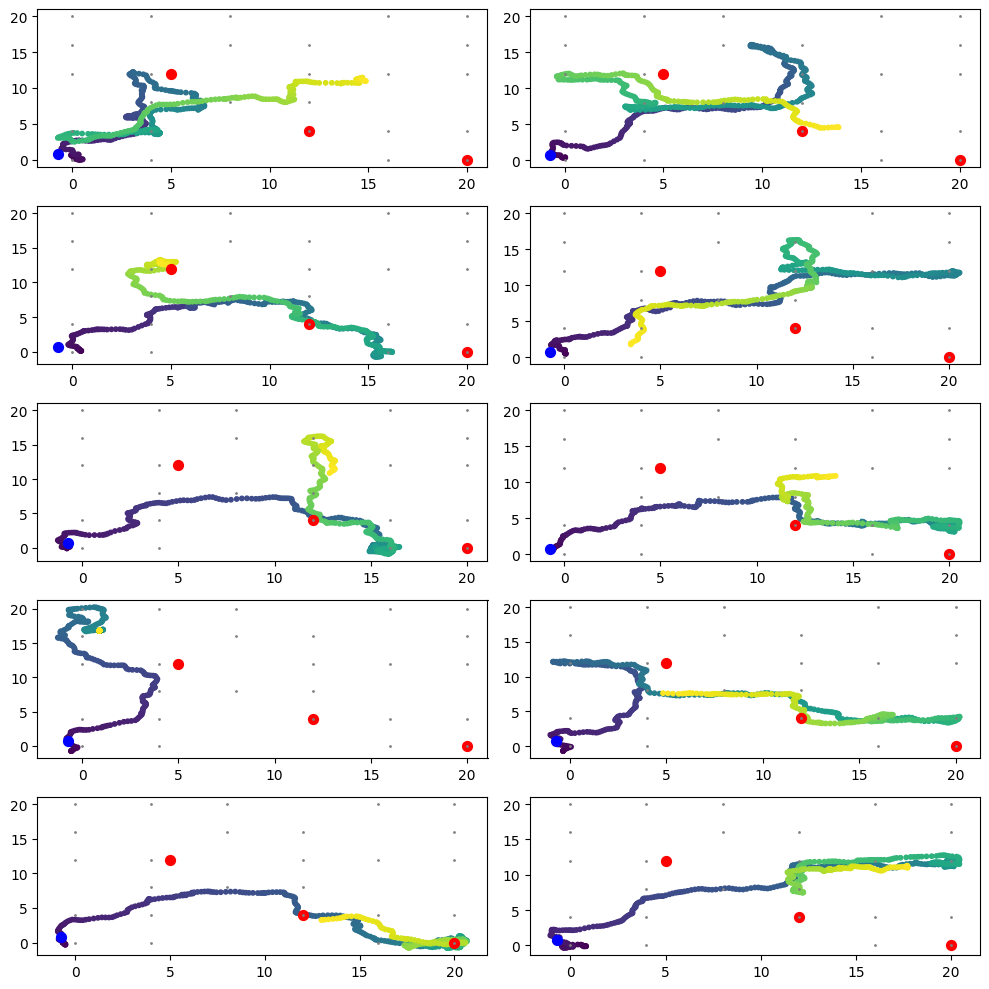

In [17]:
trajs = []
for _ in range(10):
    traj = rollout(env, actor_rn, goals, num_steps=500)
    trajs.append(traj)

fig, ax = plt.subplots(5, 2, figsize=(10, 10))
# plot_axes(ax[0], traj1)
# plot_axes(ax[1], traj2)
for i, traj in enumerate(trajs):
    # plot_axes(ax[i], traj)
    plot_axes(ax[i // 2, i % 2], traj)
plt.tight_layout()
plt.show()

100%|██████████| 500/500 [00:02<00:00, 228.55it/s]


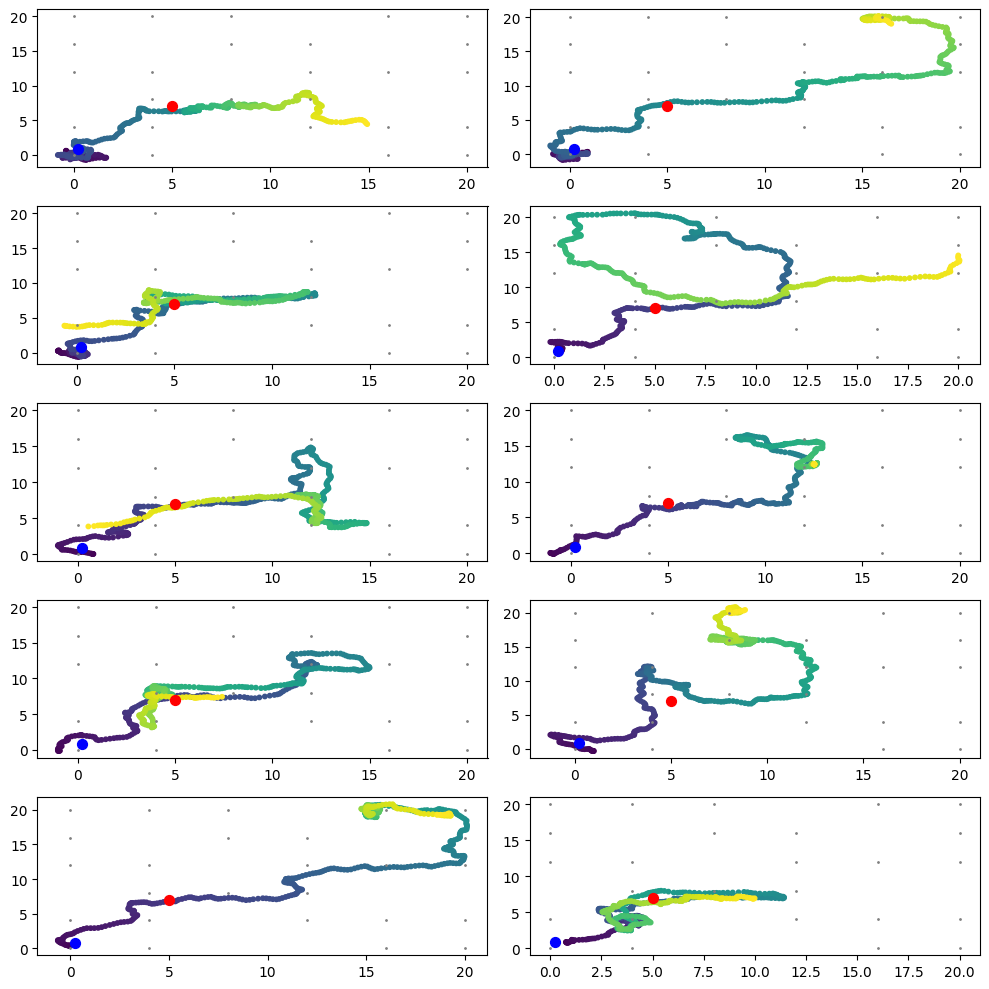

In [21]:
goals = mult_goal_obs[0]
trajs = []
for _ in range(10):
    traj = rollout(env, actor_rn, goals, num_steps=500)
    trajs.append(traj)

fig, ax = plt.subplots(5, 2, figsize=(10, 10))
# plot_axes(ax[0], traj1)
# plot_axes(ax[1], traj2)
for i, traj in enumerate(trajs):
    # plot_axes(ax[i], traj)
    plot_axes(ax[i // 2, i % 2], traj)
plt.tight_layout()
plt.show()

100%|██████████| 500/500 [00:02<00:00, 168.20it/s]


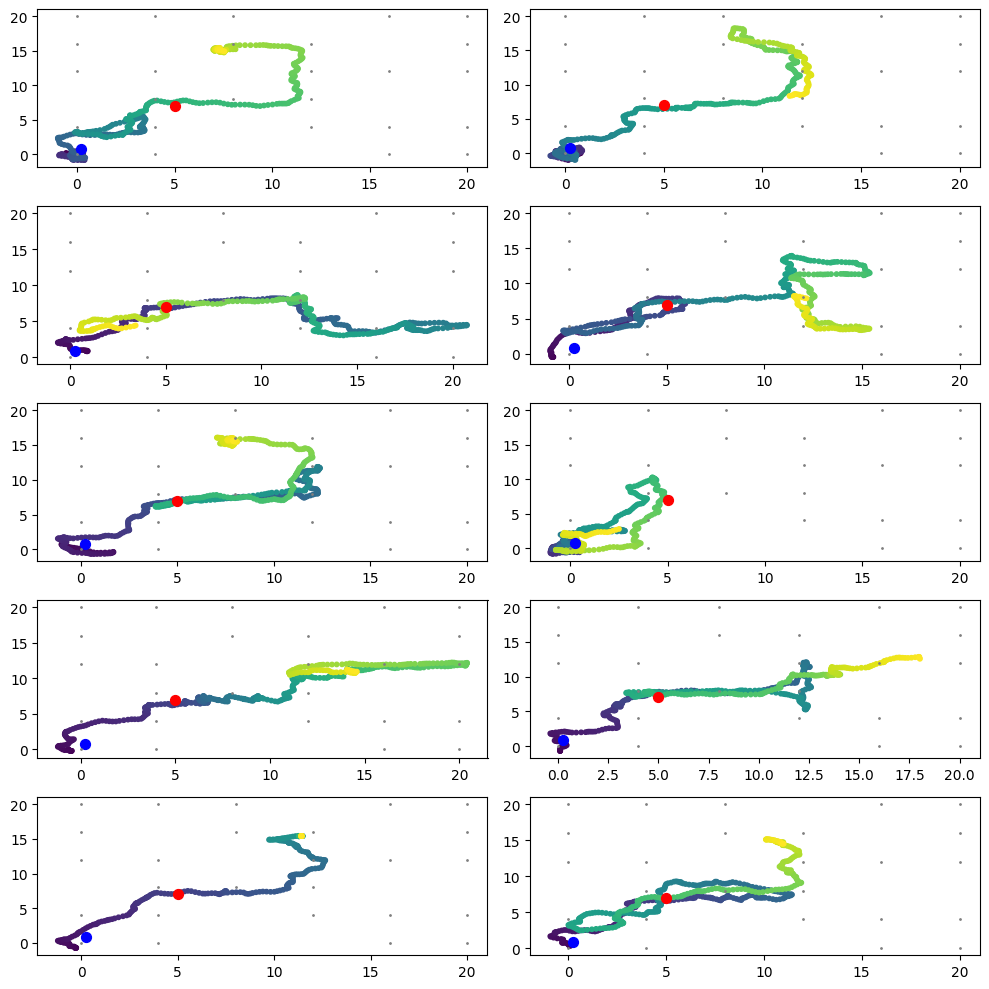

In [22]:
goals = mult_goal_obs[0]
goals = np.array([goals, goals, goals])
trajs = []
for _ in range(10):
    traj = rollout(env, actor_rn, goals, num_steps=500)
    trajs.append(traj)

fig, ax = plt.subplots(5, 2, figsize=(10, 10))
# plot_axes(ax[0], traj1)
# plot_axes(ax[1], traj2)
for i, traj in enumerate(trajs):
    # plot_axes(ax[i], traj)
    plot_axes(ax[i // 2, i % 2], traj)
plt.tight_layout()
plt.show()

100%|██████████| 500/500 [00:02<00:00, 192.07it/s]


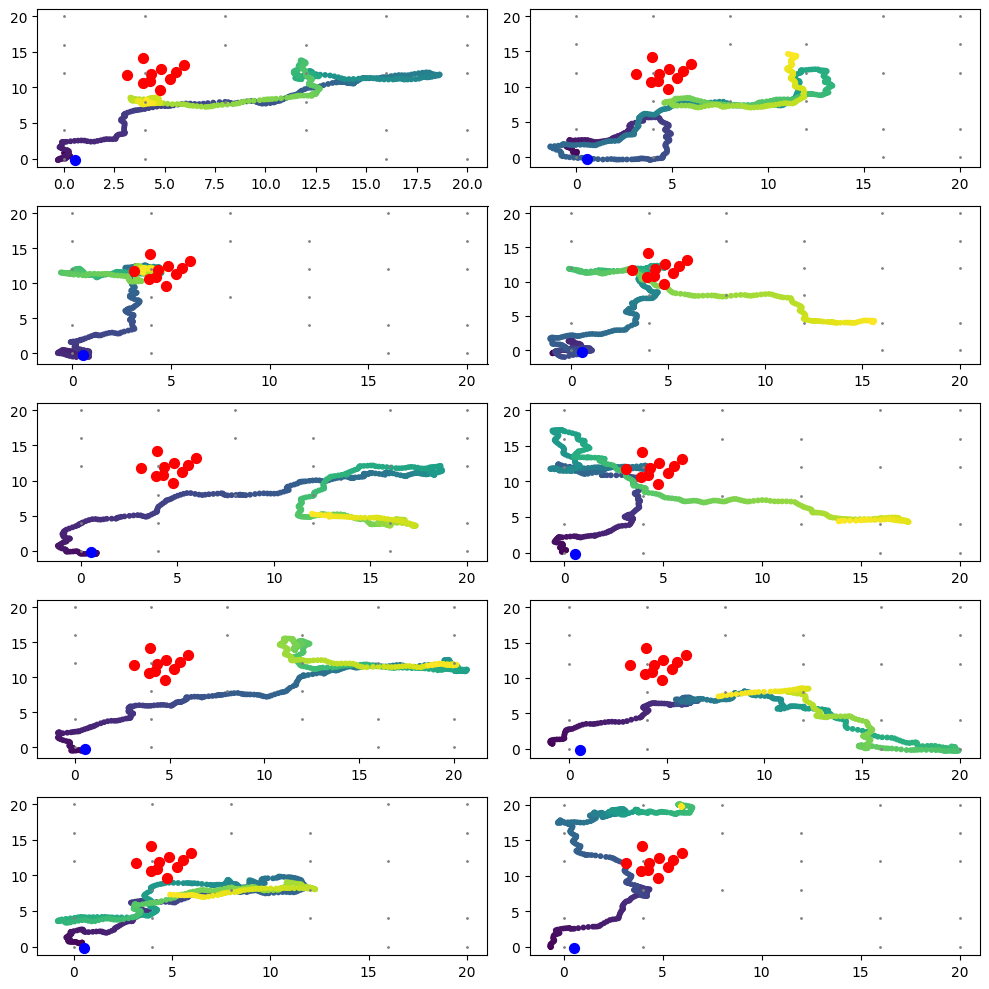

In [54]:
goalss = []

for _ in range(10):
    goals = mult_goal_obs[0] + np.random.normal(size=goals.shape)
    goalss.append(goals)
trajs = []
goalss = np.array(goalss)
for _ in range(10):
    traj = rollout(env, actor_rn, goalss, num_steps=500)
    trajs.append(traj)

fig, ax = plt.subplots(5, 2, figsize=(10, 10))
# plot_axes(ax[0], traj1)
# plot_axes(ax[1], traj2)
for i, traj in enumerate(trajs):
    # plot_axes(ax[i], traj)
    plot_axes(ax[i // 2, i % 2], traj, goals=goalss)
plt.tight_layout()
plt.show()

In [59]:
cfgrl_config['cfg']

3.0

In [71]:
cfgrl_config['cfg'] = 0.5

agent = agent_class.create(
    0,
    example_batch,
    cfgrl_config,
)
agent = restore_agent(agent, 'exp/cfgrl/Debug/sd000_20250610_120049', 1000000)

Restored from exp/cfgrl/Debug/sd000_20250610_120049/params_1000000.pkl


100%|██████████| 500/500 [00:01<00:00, 252.46it/s]


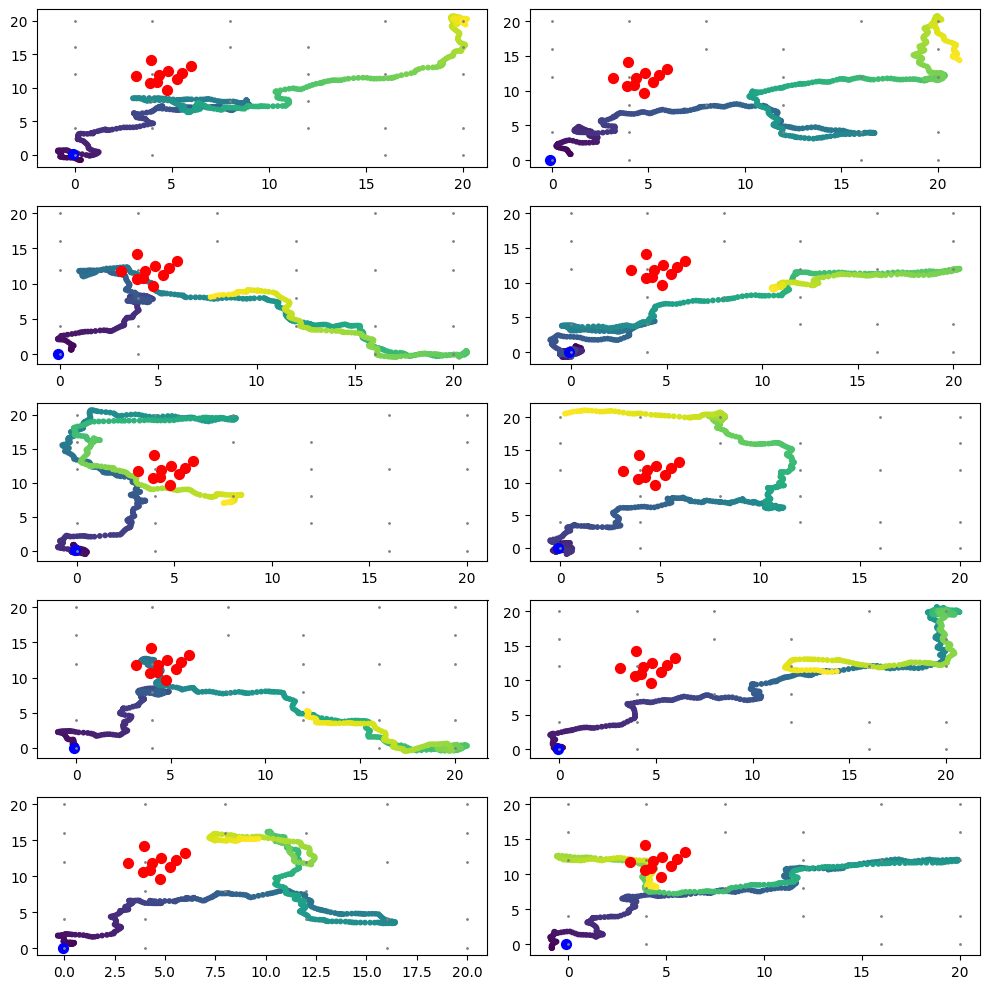

In [73]:

trajs = []
for _ in range(10):
    traj = rollout(env, goalss, agent, num_steps=500)
    trajs.append(traj)

fig, ax = plt.subplots(5, 2, figsize=(10, 10))
# plot_axes(ax[0], traj1)
# plot_axes(ax[1], traj2)
for i, traj in enumerate(trajs):
    # plot_axes(ax[i], traj)
    plot_axes(ax[i // 2, i % 2], traj, goals=goalss)
plt.tight_layout()
plt.show()

In [74]:
cfgrl_config['cfg'] = 3.0
agent = agent_class.create(
    0,
    example_batch,
    cfgrl_config,
)
agent = restore_agent(agent, 'exp/cfgrl/Debug/sd000_20250610_120049', 1000000)

Restored from exp/cfgrl/Debug/sd000_20250610_120049/params_1000000.pkl


100%|██████████| 500/500 [00:00<00:00, 547.01it/s]


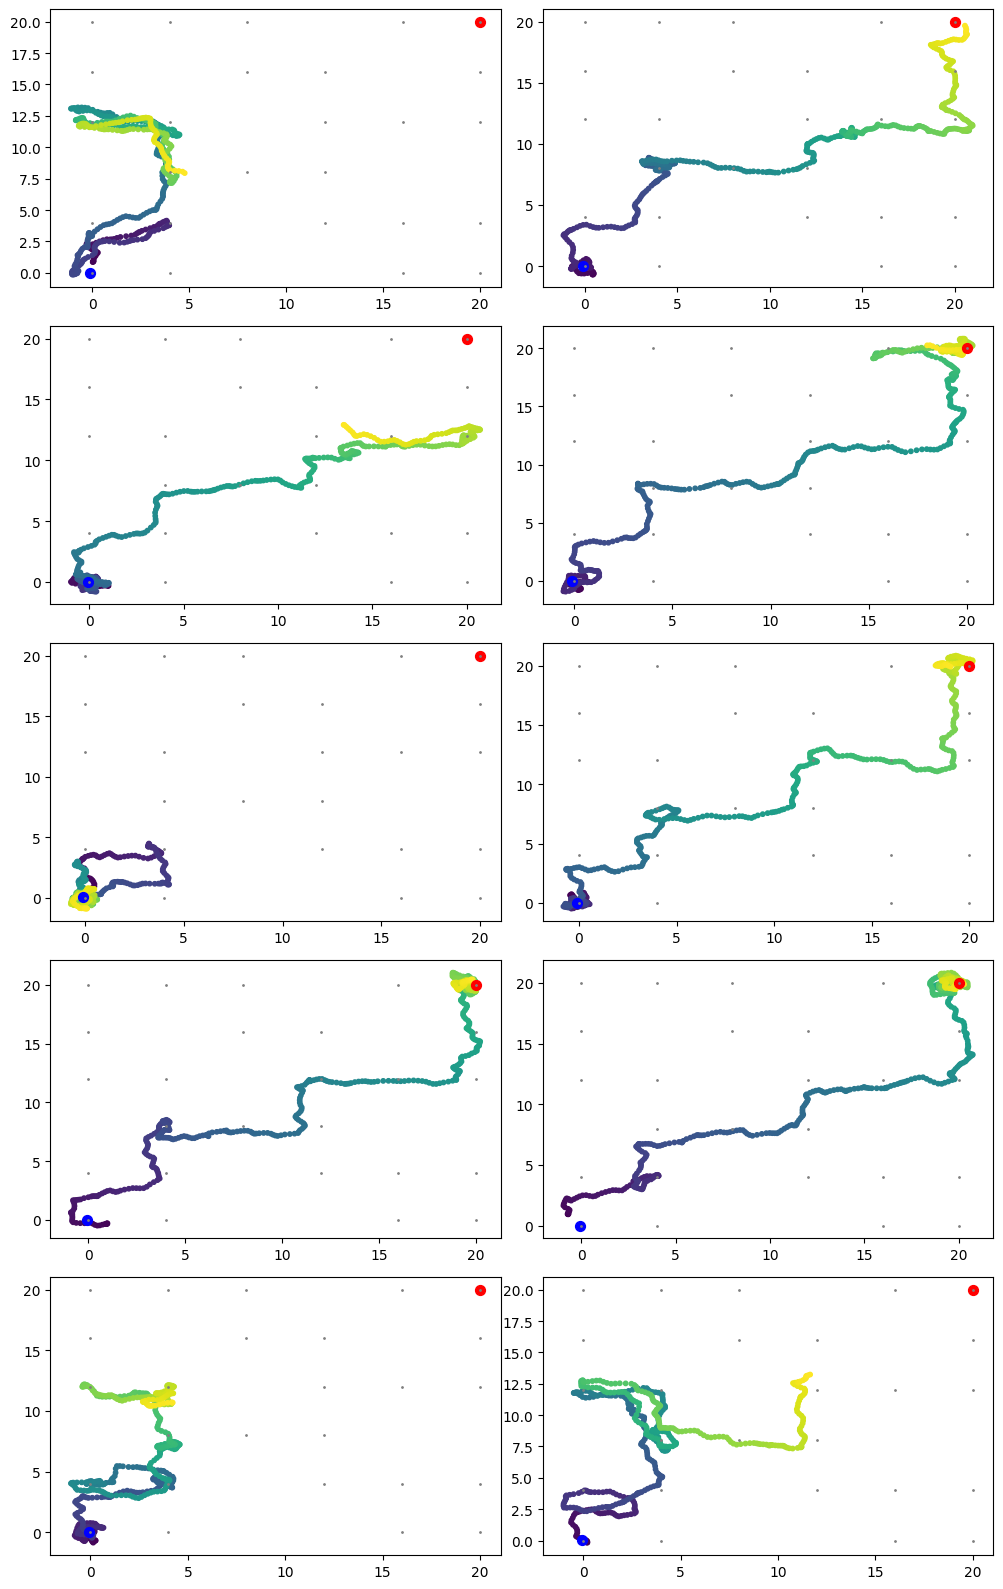

In [77]:
ob, _ = env.reset()
goal_ob = ob.copy()
goal_ob[0] = 20
goal_ob[1] = 20

noised_goals = []
for _ in range(10):
    goals = goal_ob + np.random.normal(size=goals.shape)
    noised_goals.append(goals)
noised_goals = np.array(noised_goals)

trajs = []
for _ in range(10):
    traj = rollout(env, goal_ob, agent, num_steps=500)
    trajs.append(traj)

fig, ax = plt.subplots(5, 2, figsize=(10, 16))

for i, traj in enumerate(trajs):
    plot_axes(ax[i // 2, i % 2], traj, goals=goal_ob)
plt.tight_layout()
plt.show()

100%|██████████| 500/500 [00:00<00:00, 522.94it/s]


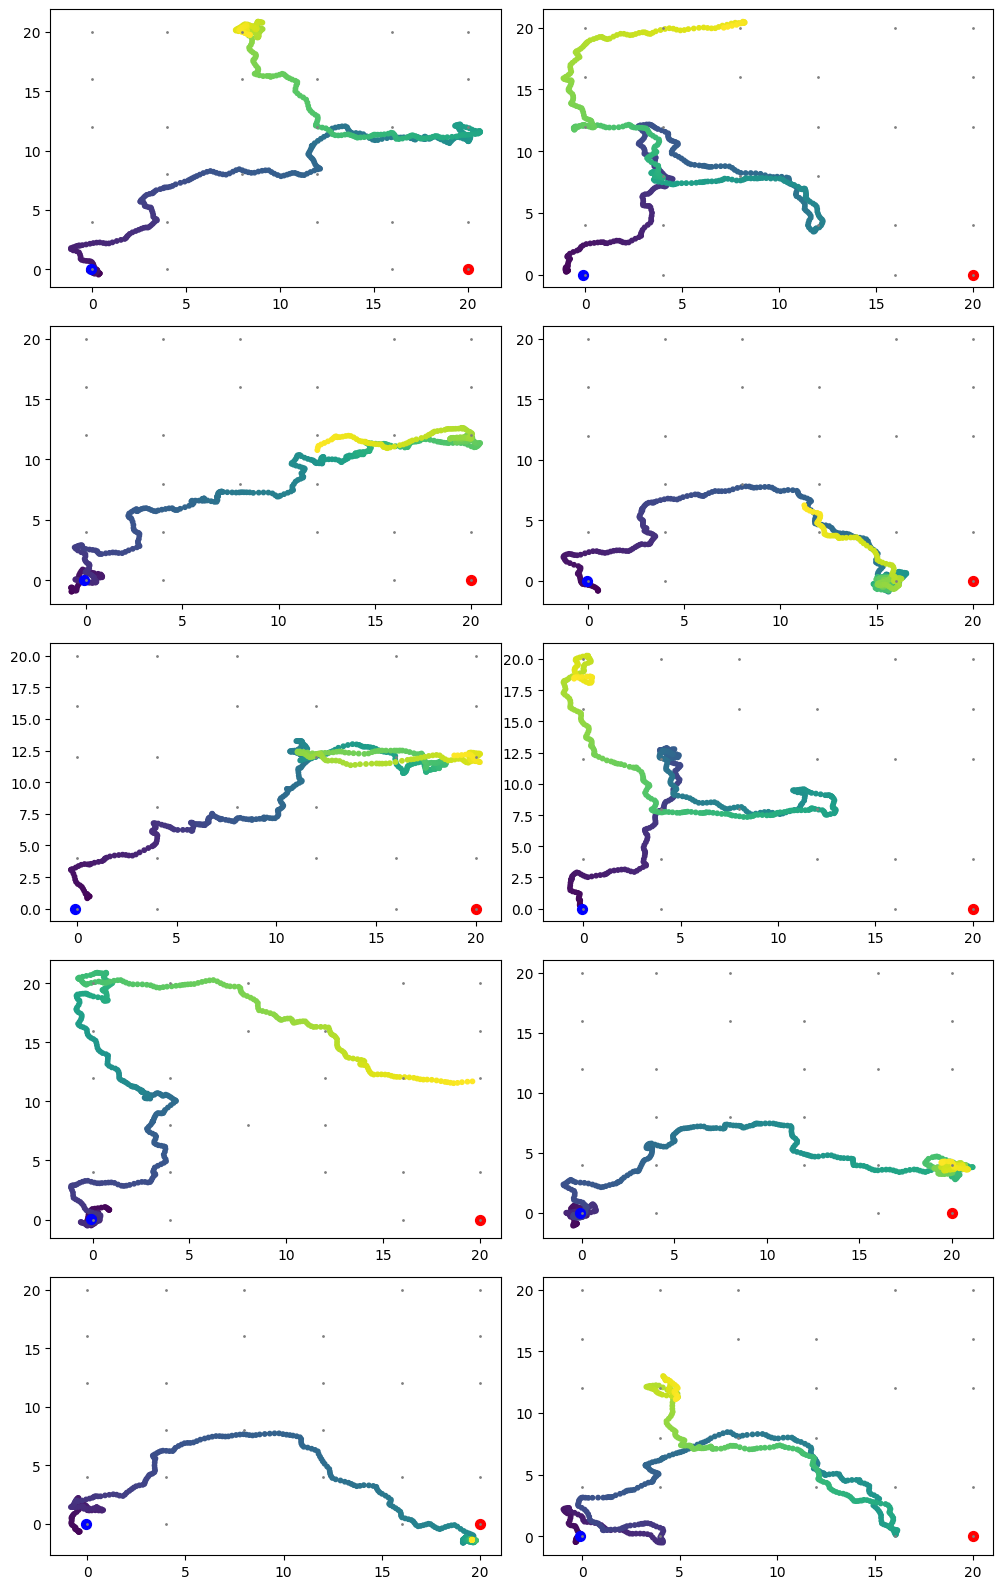

In [78]:
ob, _ = env.reset()
goal_ob = ob.copy()
goal_ob[0] = 20
goal_ob[1] = 0

noised_goals = []
for _ in range(10):
    goals = goal_ob + np.random.normal(size=goals.shape)
    noised_goals.append(goals)
noised_goals = np.array(noised_goals)

trajs = []
for _ in range(10):
    traj = rollout(env, goal_ob, agent, num_steps=500)
    trajs.append(traj)

fig, ax = plt.subplots(5, 2, figsize=(10, 16))

for i, traj in enumerate(trajs):
    plot_axes(ax[i // 2, i % 2], traj, goals=goal_ob)
plt.tight_layout()
plt.show()

100%|██████████| 500/500 [00:00<00:00, 549.79it/s]


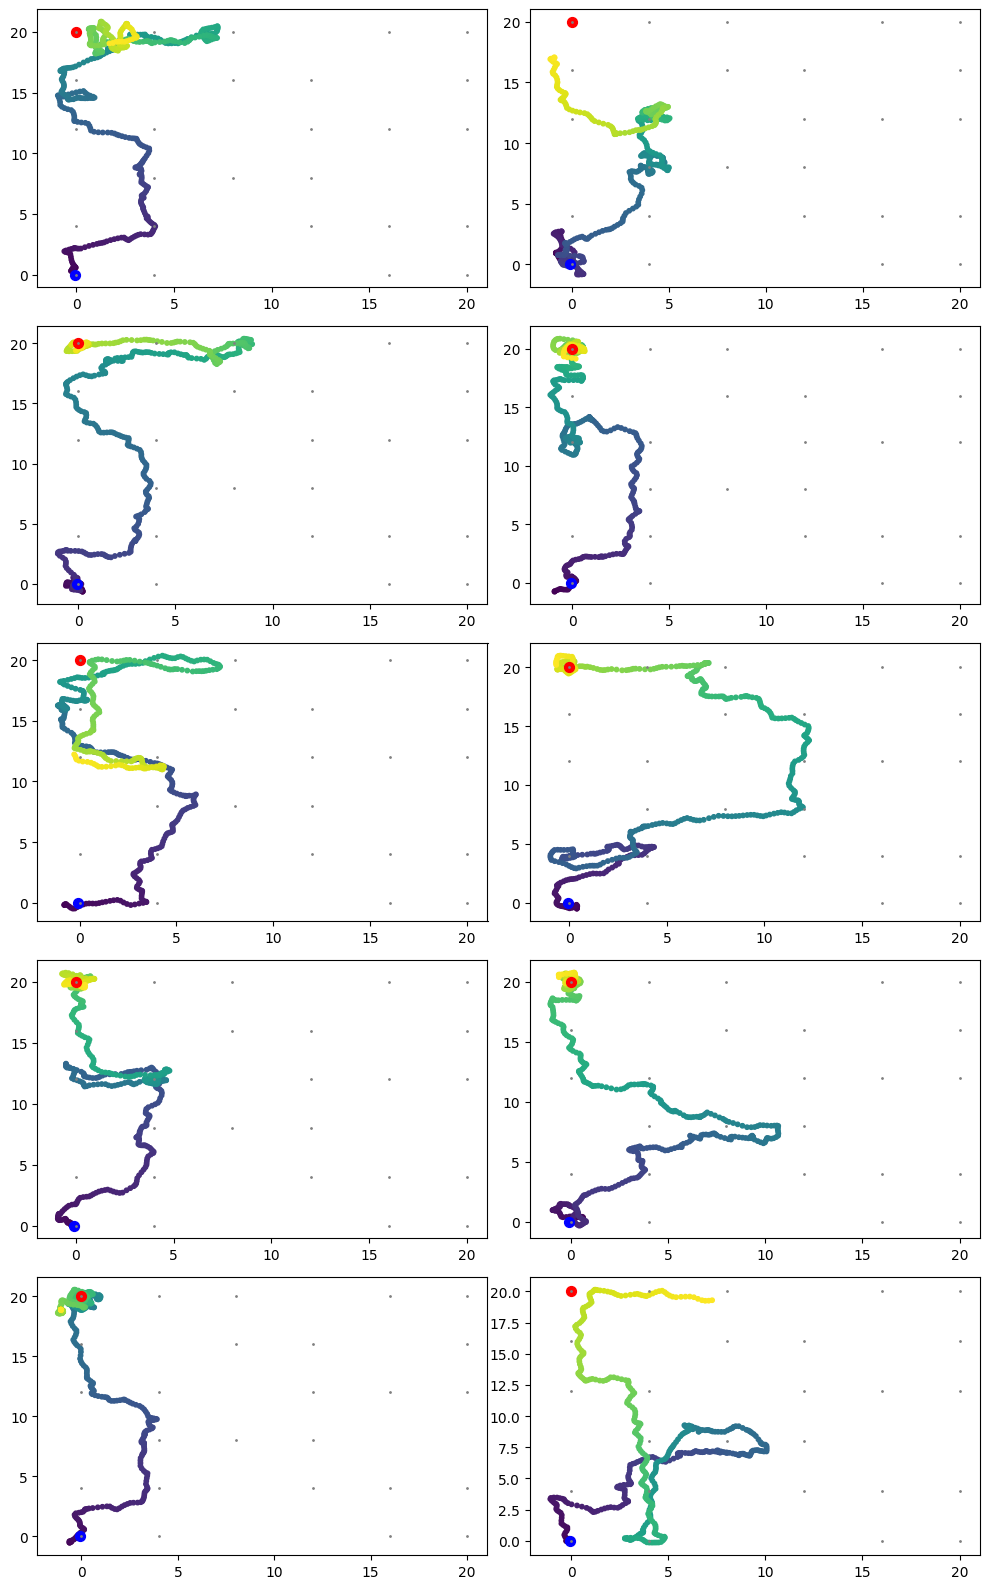

In [79]:
ob, _ = env.reset()
goal_ob = ob.copy()
goal_ob[0] = 0
goal_ob[1] = 20

noised_goals = []
for _ in range(10):
    goals = goal_ob + np.random.normal(size=goals.shape)
    noised_goals.append(goals)
noised_goals = np.array(noised_goals)

trajs = []
for _ in range(10):
    traj = rollout(env, goal_ob, agent, num_steps=500)
    trajs.append(traj)

fig, ax = plt.subplots(5, 2, figsize=(10, 16))

for i, traj in enumerate(trajs):
    plot_axes(ax[i // 2, i % 2], traj, goals=goal_ob)
plt.tight_layout()
plt.show()

100%|██████████| 500/500 [00:01<00:00, 426.42it/s]


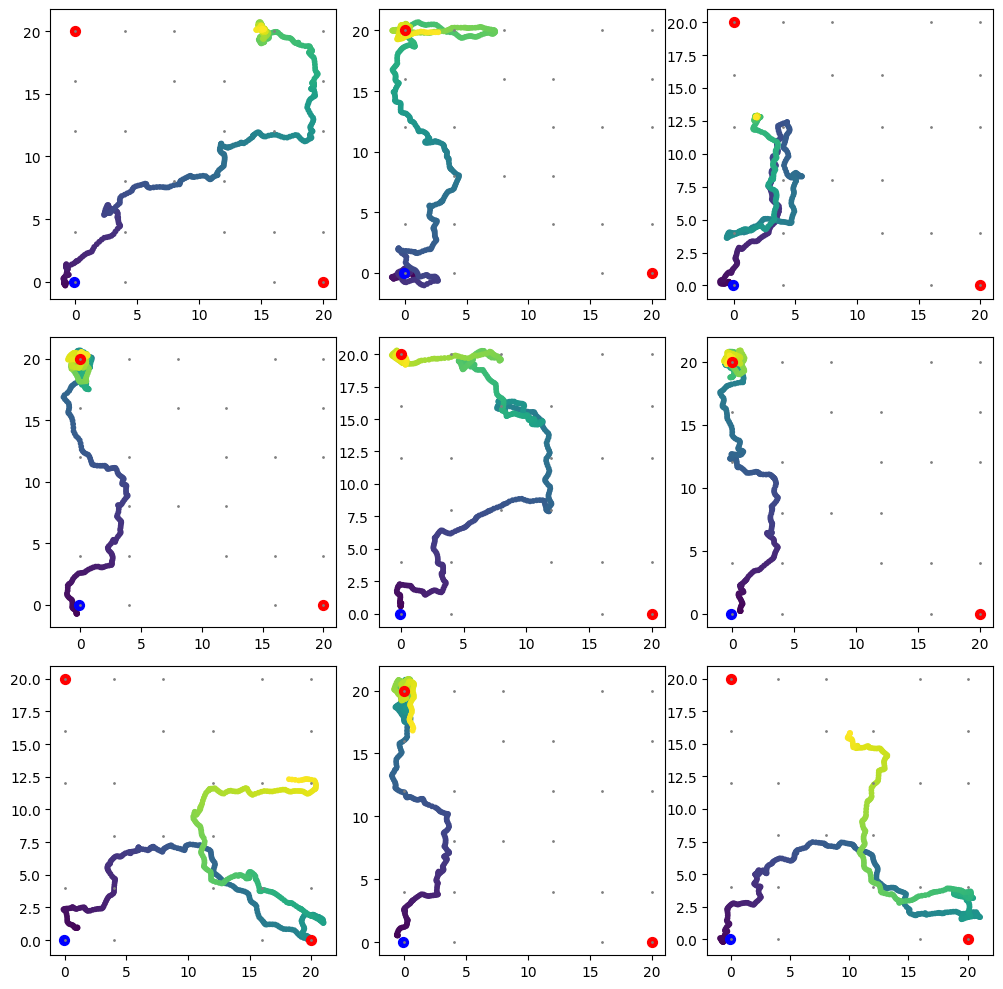

In [83]:
ob, _ = env.reset()
goal_ob = ob.copy()
goal_ob[0] = 0
goal_ob[1] = 20

goals = []
goals.append(goal_ob)

goal_ob = goal_ob.copy()
goal_ob[0] = 20
goal_ob[1] = 0
goals.append(goal_ob)
goals = np.array(goals)

# noised_goals = []
# for _ in range(10):
#     goals = goal_ob + np.random.normal(size=goals.shape)
#     noised_goals.append(goals)
# noised_goals = np.array(noised_goals)

trajs = []
for _ in range(9):
    traj = rollout(env, goals, agent, num_steps=500)
    trajs.append(traj)

fig, ax = plt.subplots(3, 3, figsize=(10, 10))

for i, traj in enumerate(trajs):
    plot_axes(ax[i // 3, i % 3], traj, goals=goals)
plt.tight_layout()
plt.show()

100%|██████████| 500/500 [00:01<00:00, 433.30it/s]


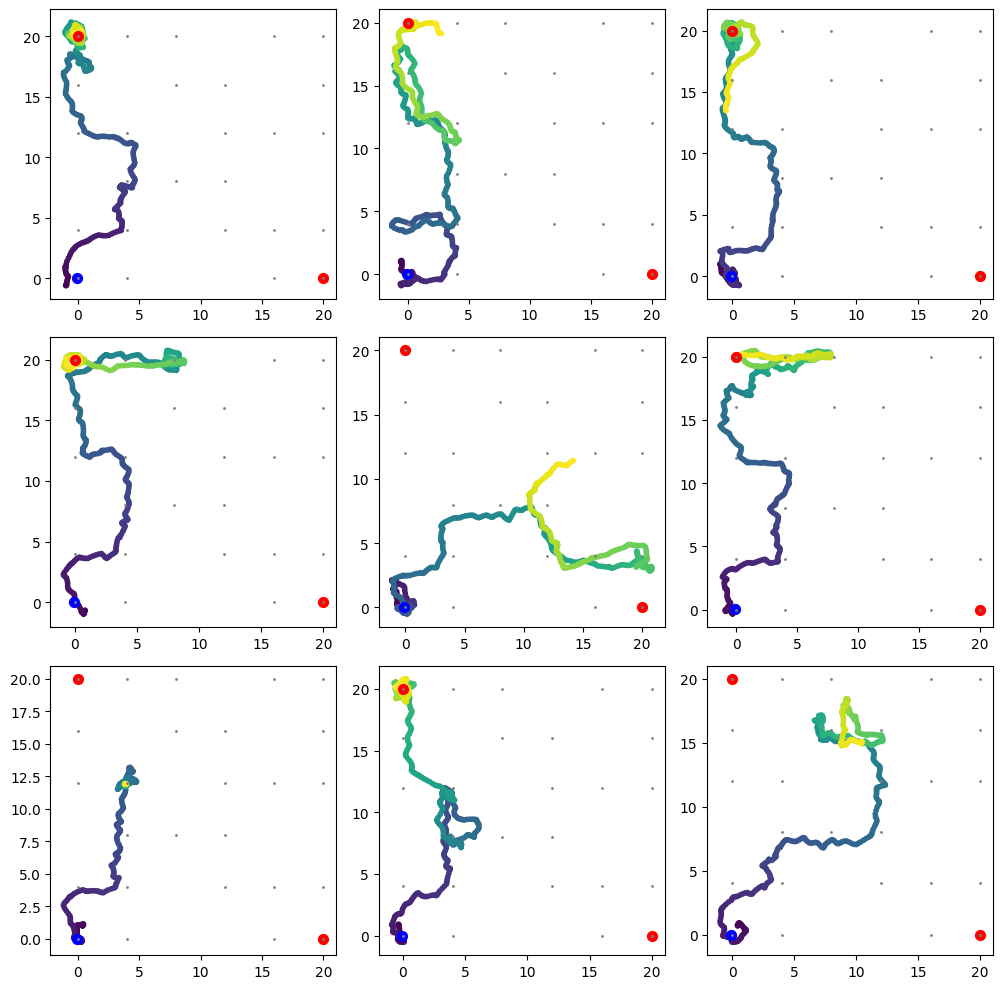

In [84]:
trajs = []
for _ in range(9):
    traj = rollout(env, goals[::-1, :], agent, num_steps=500)
    trajs.append(traj)

fig, ax = plt.subplots(3, 3, figsize=(10, 10))

for i, traj in enumerate(trajs):
    plot_axes(ax[i // 3, i % 3], traj, goals=goals[::-1, :])
plt.tight_layout()
plt.show()

100%|██████████| 500/500 [00:01<00:00, 467.00it/s]


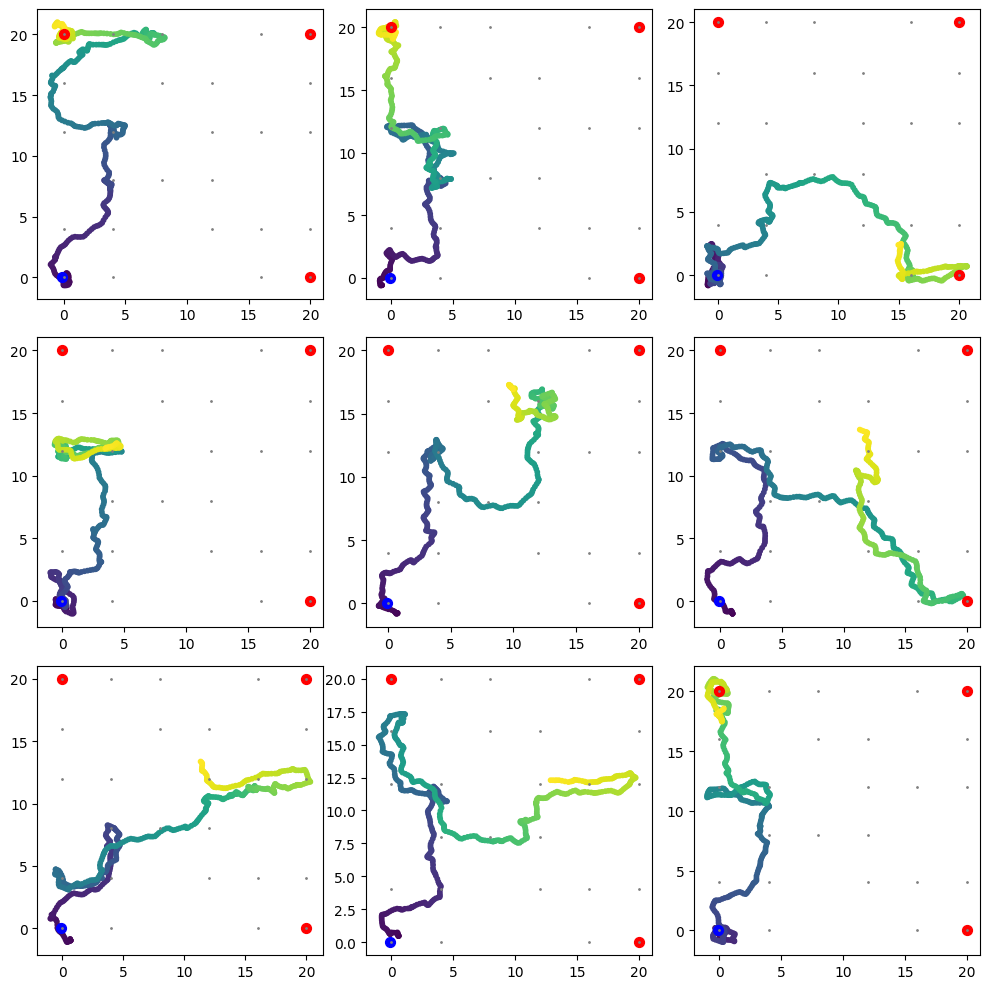

In [86]:
ob, _ = env.reset()
goal_ob = ob.copy()
goal_ob[0] = 0
goal_ob[1] = 20

goals = []
goals.append(goal_ob)

goal_ob = goal_ob.copy()
goal_ob[0] = 20
goal_ob[1] = 0
goals.append(goal_ob)

goal_ob = goal_ob.copy()
goal_ob[0] = 20
goal_ob[1] = 20
goals.append(goal_ob)
goals = np.array(goals)

# noised_goals = []
# for _ in range(10):
#     goals = goal_ob + np.random.normal(size=goals.shape)
#     noised_goals.append(goals)
# noised_goals = np.array(noised_goals)

trajs = []
for _ in range(9):
    traj = rollout(env, goals, agent, num_steps=500)
    trajs.append(traj)

fig, ax = plt.subplots(3, 3, figsize=(10, 10))

for i, traj in enumerate(trajs):
    plot_axes(ax[i // 3, i % 3], traj, goals=goals)
plt.tight_layout()
plt.show()

100%|██████████| 500/500 [00:06<00:00, 82.92it/s]


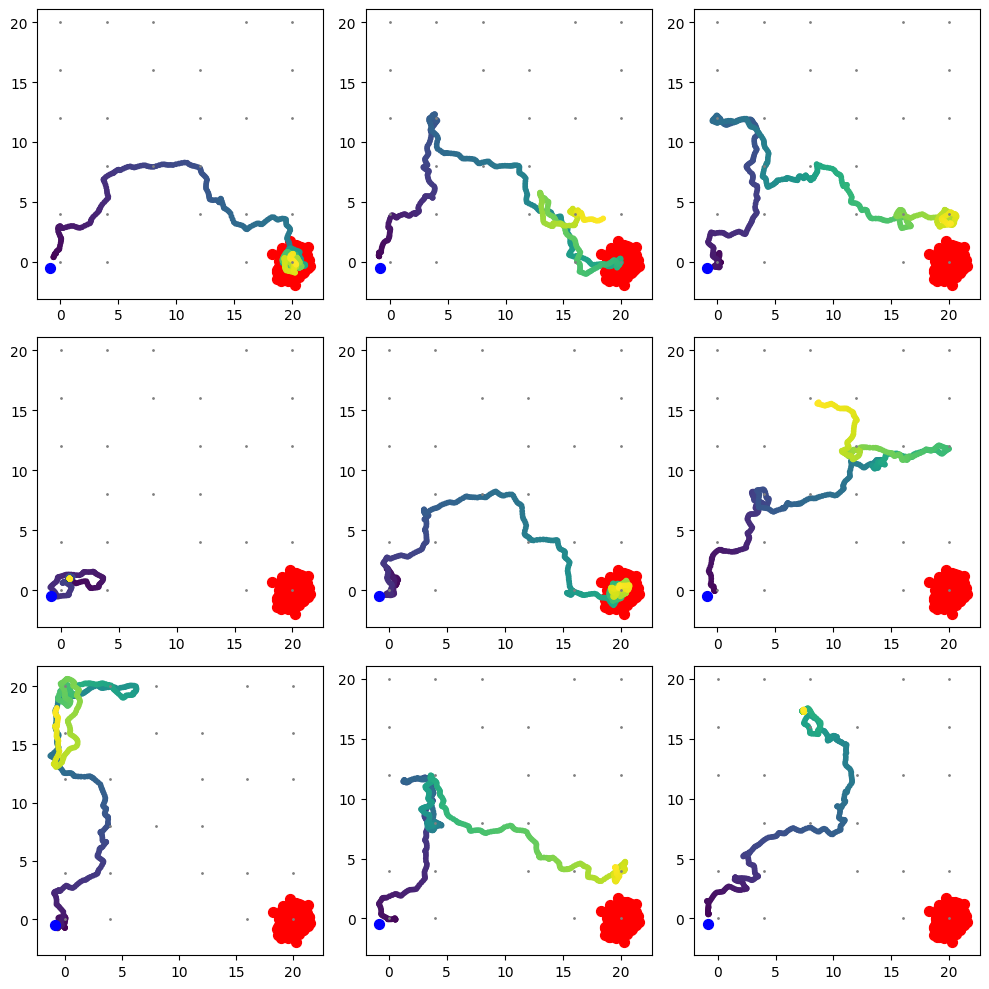

In [98]:
ob, _ = env.reset()
goal_ob = ob.copy()
goal_ob[0] = 20
goal_ob[1] = 0

noised_goals = []
for _ in range(1000):
    goals = goal_ob + 0.5 * np.random.normal(size=goal_ob.shape)
    noised_goals.append(goals)
noised_goals = np.array(noised_goals)

trajs = []
for _ in range(9):
    traj = rollout(env, noised_goals, agent, num_steps=500)
    trajs.append(traj)

fig, ax = plt.subplots(3, 3, figsize=(10, 10))

for i, traj in enumerate(trajs):
    plot_axes(ax[i // 3, i % 3], traj, all_cells=all_cells, goals=noised_goals)
plt.tight_layout()
plt.show()

100%|██████████| 500/500 [00:01<00:00, 392.86it/s]


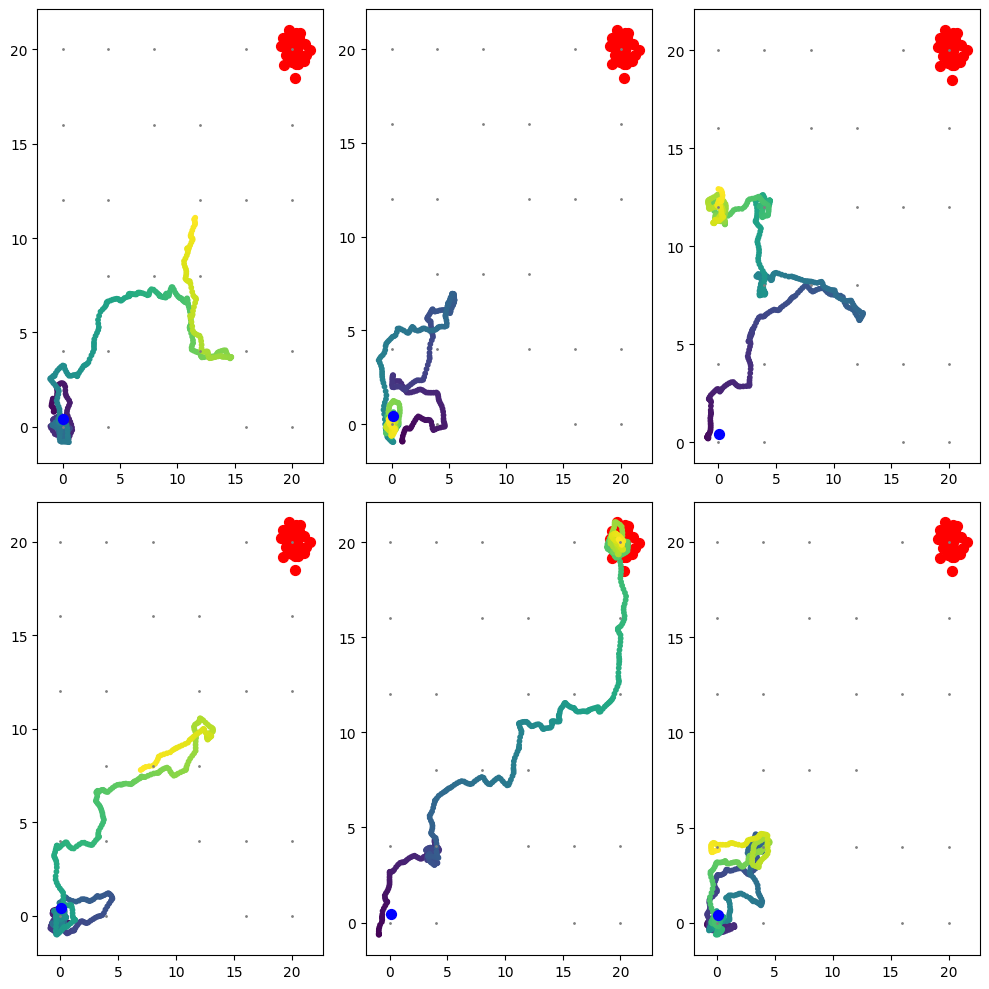

In [106]:
ob, _ = env.reset()
goal_ob = ob.copy()
goal_ob[0] = 20
goal_ob[1] = 20

noised_goals = []
for _ in range(50):
    goals = goal_ob + 0.5 * np.random.normal(size=goal_ob.shape)
    noised_goals.append(goals)
noised_goals = np.array(noised_goals)

trajs = []
for _ in range(6):
    traj = rollout(env, noised_goals, agent, num_steps=500, temperature=0.2)
    trajs.append(traj)

fig, ax = plt.subplots(2, 3, figsize=(10, 10))

for i, traj in enumerate(trajs):
    plot_axes(ax[i // 3, i % 3], traj, all_cells=all_cells, goals=noised_goals)
plt.tight_layout()
plt.show()

  0%|          | 0/500 [00:00<?, ?it/s]

100%|██████████| 500/500 [00:01<00:00, 398.15it/s]


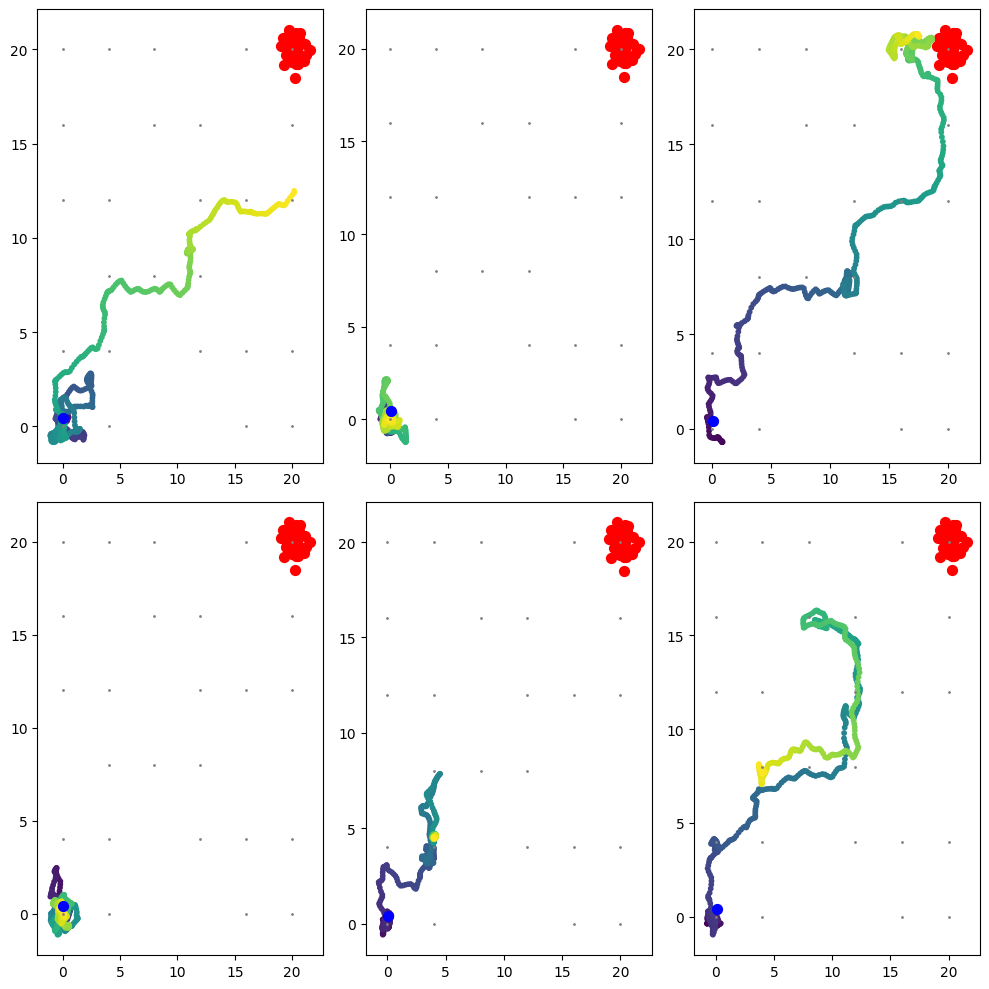

In [107]:
trajs = []
for _ in range(6):
    traj = rollout(env, noised_goals, agent, num_steps=500, temperature=20)
    trajs.append(traj)

fig, ax = plt.subplots(2, 3, figsize=(10, 10))

for i, traj in enumerate(trajs):
    plot_axes(ax[i // 3, i % 3], traj, all_cells=all_cells, goals=noised_goals)
plt.tight_layout()
plt.show()

# Using the Agent that was Pre-trained on the Stich Data

In [108]:
cfgrl_config = get_config()
agent = agent_class.create(
    0,
    example_batch,
    cfgrl_config,
)
agent = restore_agent(agent, 'exp/cfgrl/Debug/sd000_20250610_172218', 1000000)

Restored from exp/cfgrl/Debug/sd000_20250610_172218/params_1000000.pkl


In [112]:
nav_agent = agent_class.create(
    0,
    example_batch,
    cfgrl_config,
)
nav_agent = restore_agent(nav_agent, 'exp/cfgrl/Debug/sd000_20250610_120049', 1000000)

Restored from exp/cfgrl/Debug/sd000_20250610_120049/params_1000000.pkl


100%|██████████| 500/500 [00:01<00:00, 403.96it/s]


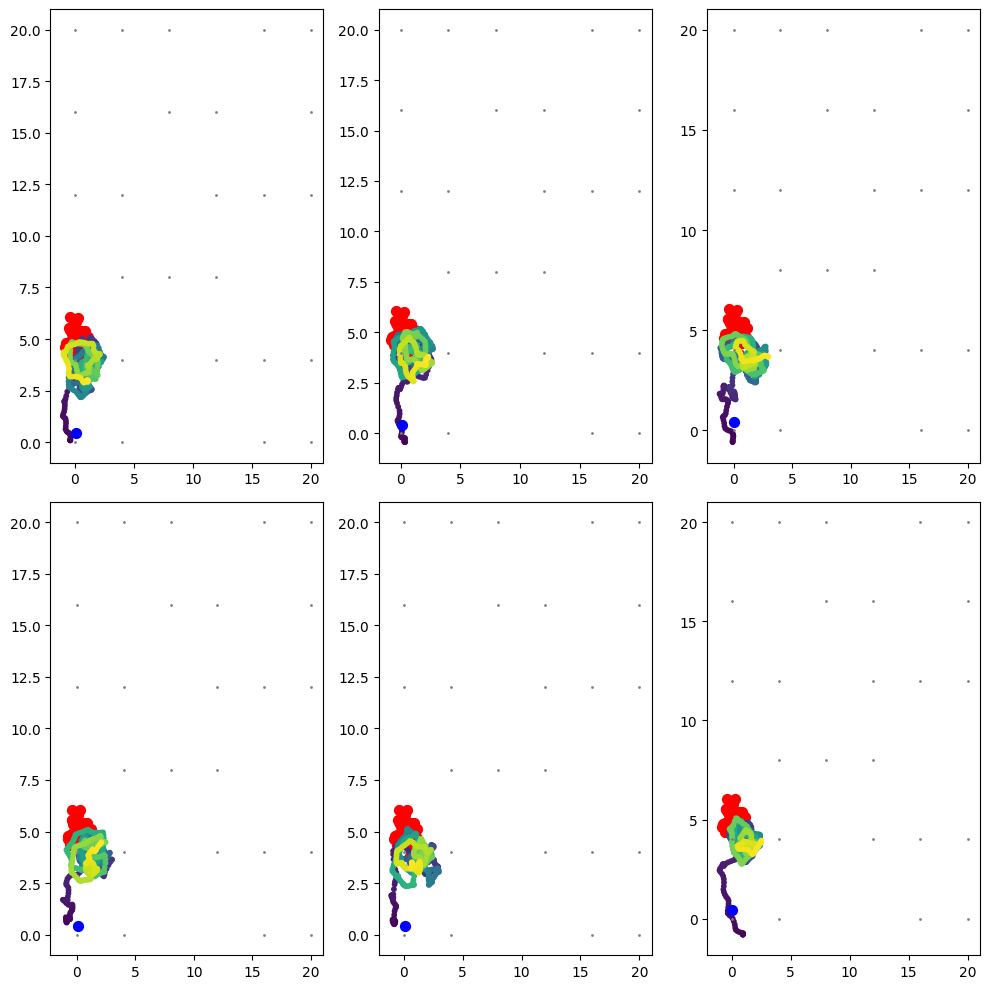

In [ ]:
ob, _ = env.reset()
goal_ob = ob.copy()
goal_ob[0] = 0
goal_ob[1] = 5

noised_goals = []
for _ in range(50):
    goals = goal_ob + 0.5 * np.random.normal(size=goal_ob.shape)
    noised_goals.append(goals)
noised_goals = np.array(noised_goals)


trajs = []
for _ in range(6):
    traj = rollout(env, noised_goals, agent, num_steps=500, temperature=0.2)
    trajs.append(traj)

fig, ax = plt.subplots(2, 3, figsize=(10, 10))

for i, traj in enumerate(trajs):
    plot_axes(ax[i // 3, i % 3], traj, all_cells=all_cells, goals=noised_goals)
plt.tight_layout()
plt.show()

100%|██████████| 500/500 [00:01<00:00, 393.14it/s]


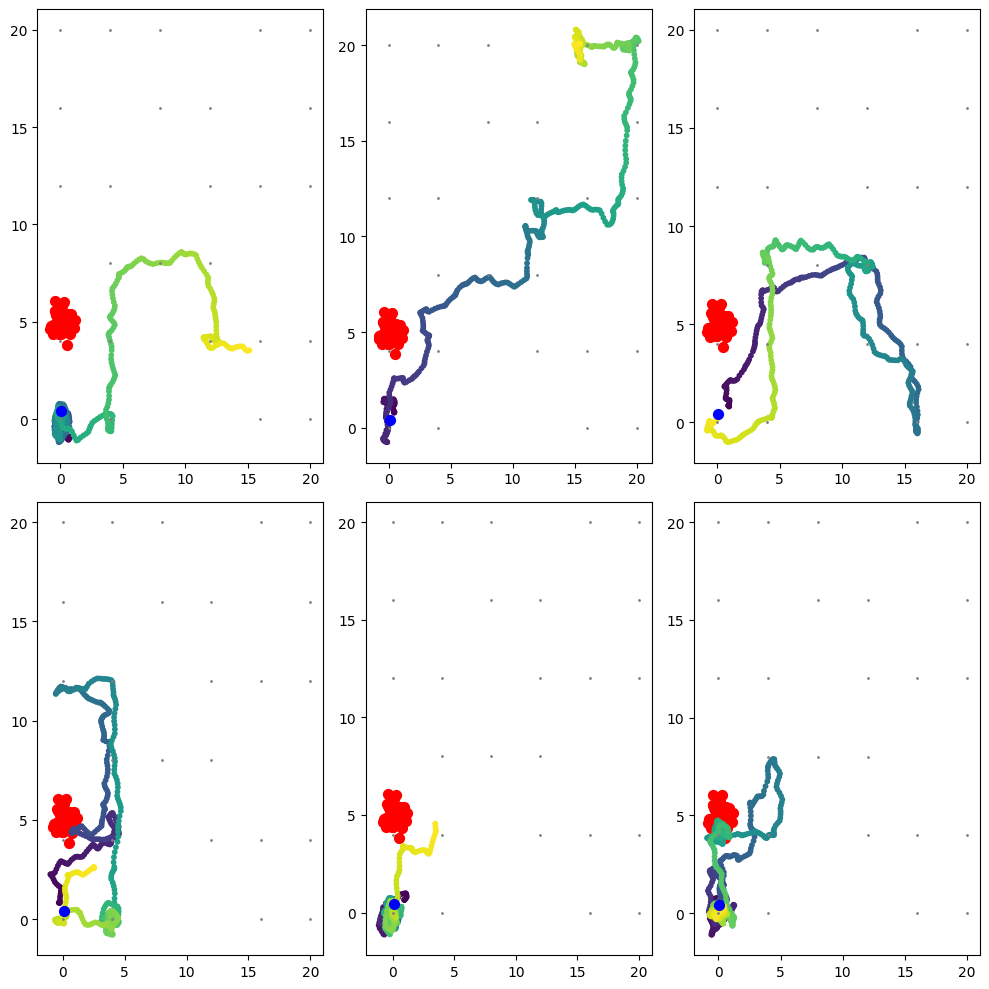

In [113]:
trajs = []
for _ in range(6):
    traj = rollout(env, noised_goals, nav_agent, num_steps=500, temperature=0.2)
    trajs.append(traj)

fig, ax = plt.subplots(2, 3, figsize=(10, 10))

for i, traj in enumerate(trajs):
    plot_axes(ax[i // 3, i % 3], traj, all_cells=all_cells, goals=noised_goals)
plt.tight_layout()
plt.show()

# CFGRL Agent Trained on the 10x Dataset

In [13]:
agent = restore_agent(agent, 'exp/cfgrl/Debug/sd000_20250611_101750', 1000000)

Restored from exp/cfgrl/Debug/sd000_20250611_101750/params_1000000.pkl


In [16]:
from utils.evaluation import supply_rng

100%|██████████| 500/500 [00:01<00:00, 336.37it/s]


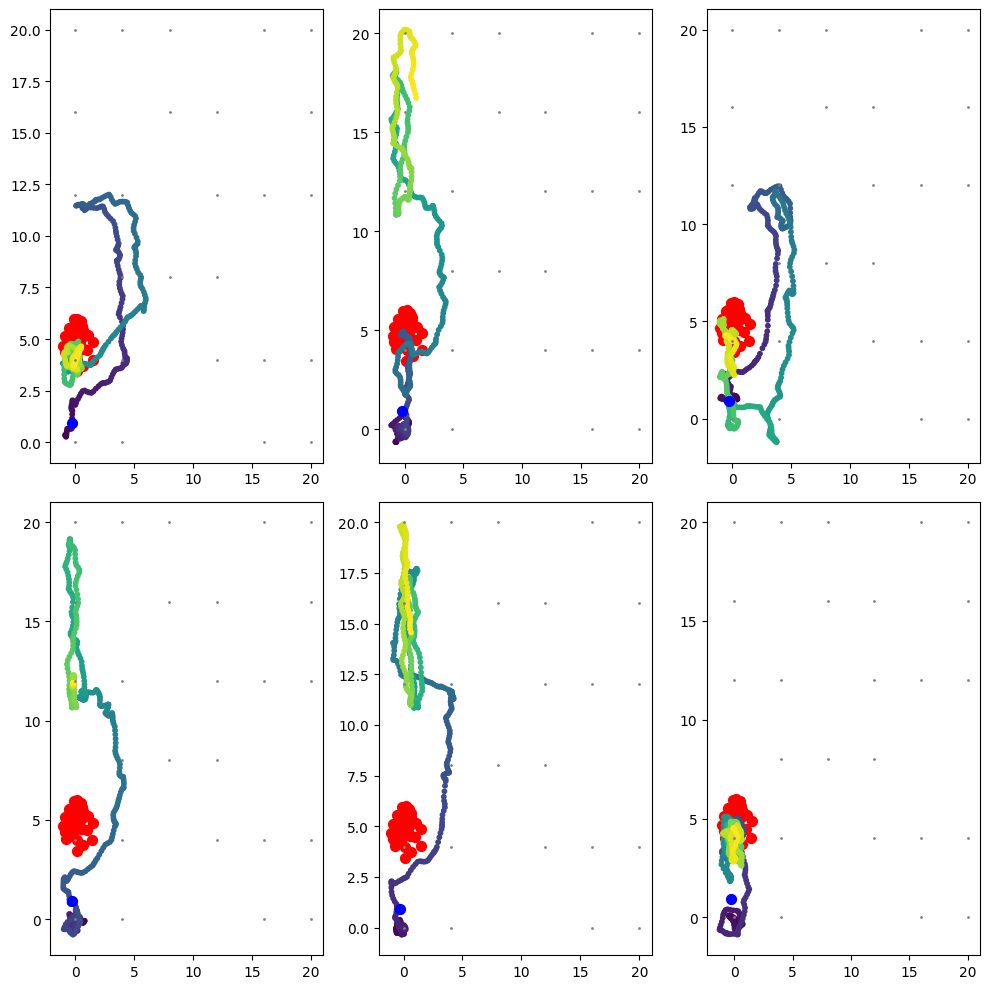

In [17]:
ob, _ = env.reset()
goal_ob = ob.copy()
goal_ob[0] = 0
goal_ob[1] = 5

noised_goals = []
for _ in range(50):
    goals = goal_ob + 0.5 * np.random.normal(size=goal_ob.shape)
    noised_goals.append(goals)
noised_goals = np.array(noised_goals)

trajs = []
for _ in range(6):
    traj = rollout(env, noised_goals, agent, num_steps=500, temperature=0.2)
    trajs.append(traj)

fig, ax = plt.subplots(2, 3, figsize=(10, 10))

for i, traj in enumerate(trajs):
    plot_axes(ax[i // 3, i % 3], traj, all_cells=all_cells, goals=noised_goals)
plt.tight_layout()
plt.show()

100%|██████████| 500/500 [00:01<00:00, 376.84it/s]


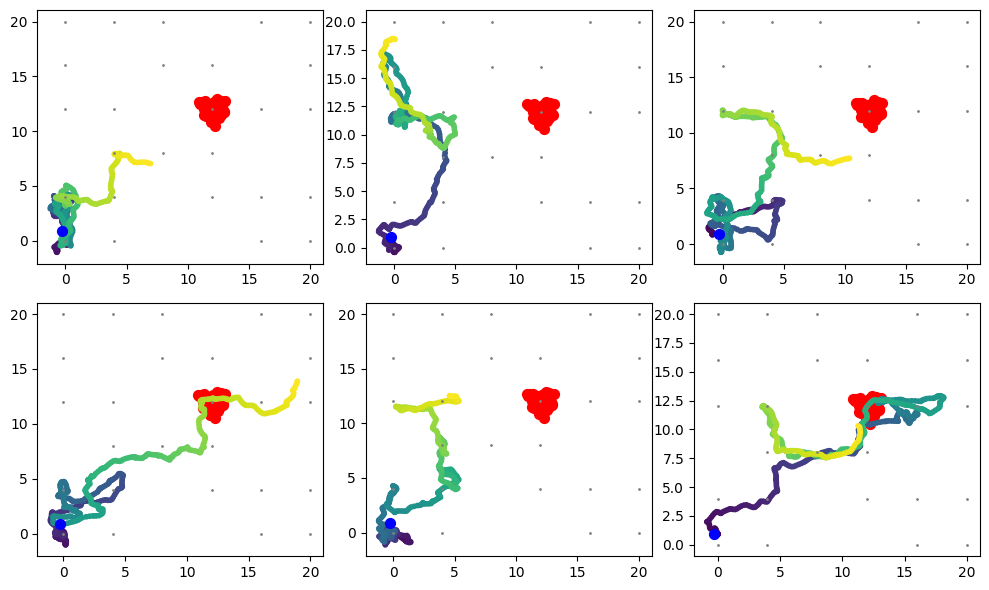

In [18]:
ob, _ = env.reset()
goal_ob = ob.copy()
goal_ob[0] = 12
goal_ob[1] = 12

noised_goals = []
for _ in range(50):
    goals = goal_ob + 0.5 * np.random.normal(size=goal_ob.shape)
    noised_goals.append(goals)
noised_goals = np.array(noised_goals)

trajs = []
for _ in range(6):
    traj = rollout(env, noised_goals, agent, num_steps=500, temperature=0.2)
    trajs.append(traj)

fig, ax = plt.subplots(2, 3, figsize=(10, 6))

for i, traj in enumerate(trajs):
    plot_axes(ax[i // 3, i % 3], traj, all_cells=all_cells, goals=noised_goals)
plt.tight_layout()
plt.show()

In [19]:
stitch_agent = agent_class.create(
    0,
    example_batch,
    cfgrl_config,
)
stitch_agent = restore_agent(stitch_agent, 'exp/cfgrl/Debug/sd000_20250610_172218', 1000000)

nav_agent = agent_class.create(
    0,
    example_batch,
    cfgrl_config,
)
nav_agent = restore_agent(nav_agent, 'exp/cfgrl/Debug/sd000_20250610_120049', 1000000)

Restored from exp/cfgrl/Debug/sd000_20250610_172218/params_1000000.pkl
Restored from exp/cfgrl/Debug/sd000_20250610_120049/params_1000000.pkl


In [20]:
tenx_nav_agent = agent

100%|██████████| 500/500 [00:01<00:00, 380.56it/s]


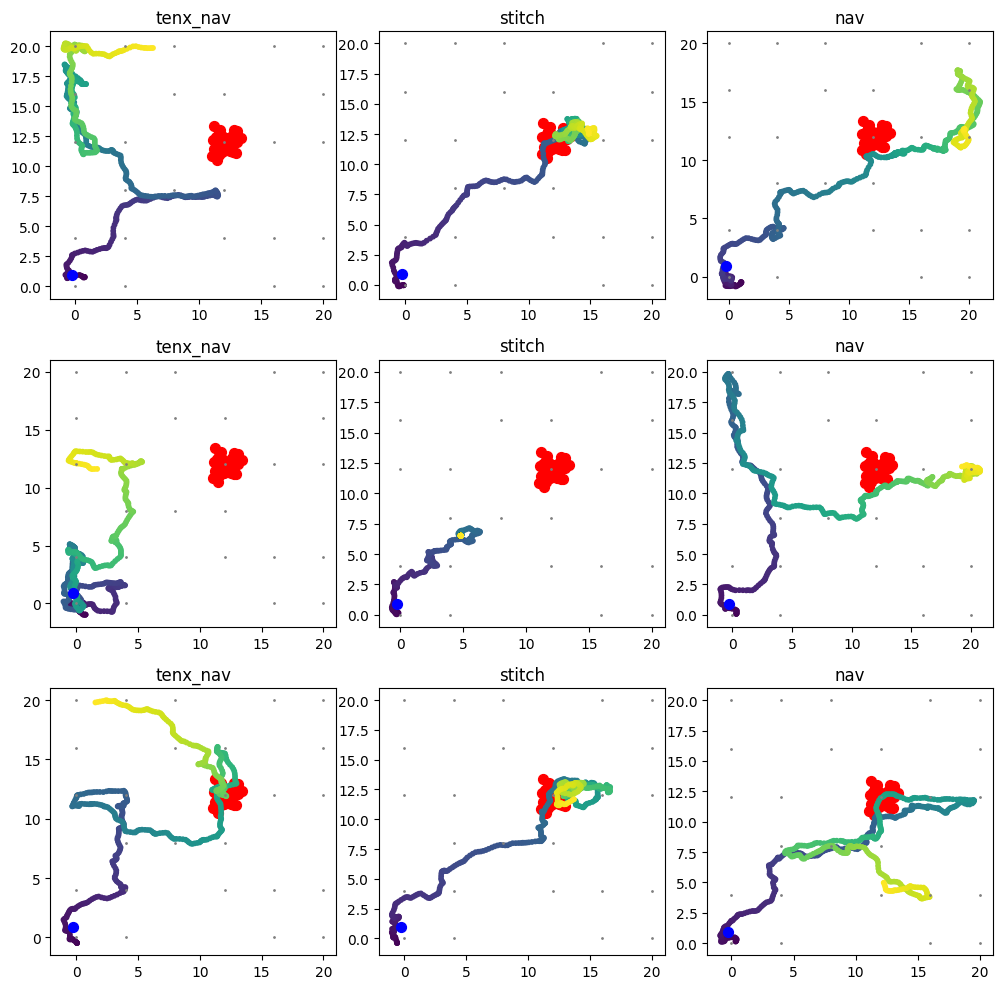

In [22]:
ob, _ = env.reset()
goal_ob = ob.copy()
goal_ob[0] = 12
goal_ob[1] = 12

noised_goals = []
for _ in range(50):
    goals = goal_ob + 0.5 * np.random.normal(size=goal_ob.shape)
    noised_goals.append(goals)
noised_goals = np.array(noised_goals)

trajs = {'tenx_nav': [], 'stitch': [], 'nav': []}
for _ in range(3):
    # traj = rollout(env, noised_goals, agent, num_steps=500, temperature=0.2)
    # trajs.append(traj)
    for curr_agent, name in zip([tenx_nav_agent, stitch_agent, nav_agent], ['tenx_nav', 'stitch', 'nav']):
        traj = rollout(env, noised_goals, curr_agent, num_steps=500, temperature=0.2)
        trajs[name].append(traj)

fig, ax = plt.subplots(3, 3, figsize=(10, 10))

# for i, traj in enumerate(trajs):
#     plot_axes(ax[i // 3, i % 3], traj, all_cells=all_cells, goals=noised_goals)
for i, (name, traj_list) in enumerate(trajs.items()):
    for j, traj in enumerate(traj_list):
        plot_axes(ax[j, i], traj, all_cells=all_cells, goals=noised_goals)
        ax[j, i].set_title(name)
plt.tight_layout()
plt.show()

100%|██████████| 500/500 [00:01<00:00, 370.95it/s]


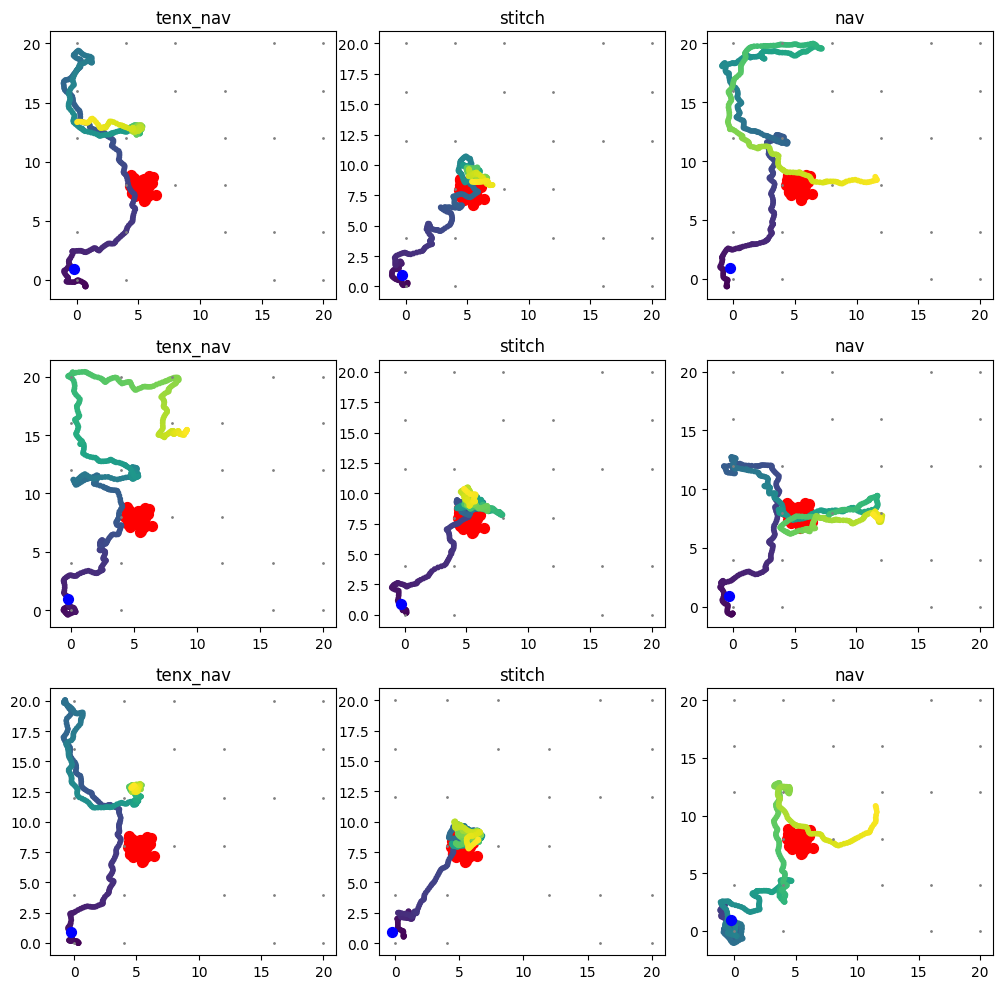

In [23]:
ob, _ = env.reset()
goal_ob = ob.copy()
goal_ob[0] = 5
goal_ob[1] = 8

noised_goals = []
for _ in range(50):
    goals = goal_ob + 0.5 * np.random.normal(size=goal_ob.shape)
    noised_goals.append(goals)
noised_goals = np.array(noised_goals)

trajs = {'tenx_nav': [], 'stitch': [], 'nav': []}
for _ in range(3):
    # traj = rollout(env, noised_goals, agent, num_steps=500, temperature=0.2)
    # trajs.append(traj)
    for curr_agent, name in zip([tenx_nav_agent, stitch_agent, nav_agent], ['tenx_nav', 'stitch', 'nav']):
        traj = rollout(env, noised_goals, curr_agent, num_steps=500, temperature=0.2)
        trajs[name].append(traj)

fig, ax = plt.subplots(3, 3, figsize=(10, 10))

# for i, traj in enumerate(trajs):
#     plot_axes(ax[i // 3, i % 3], traj, all_cells=all_cells, goals=noised_goals)
for i, (name, traj_list) in enumerate(trajs.items()):
    for j, traj in enumerate(traj_list):
        plot_axes(ax[j, i], traj, all_cells=all_cells, goals=noised_goals)
        ax[j, i].set_title(name)
plt.tight_layout()
plt.show()

100%|██████████| 500/500 [00:01<00:00, 497.30it/s]


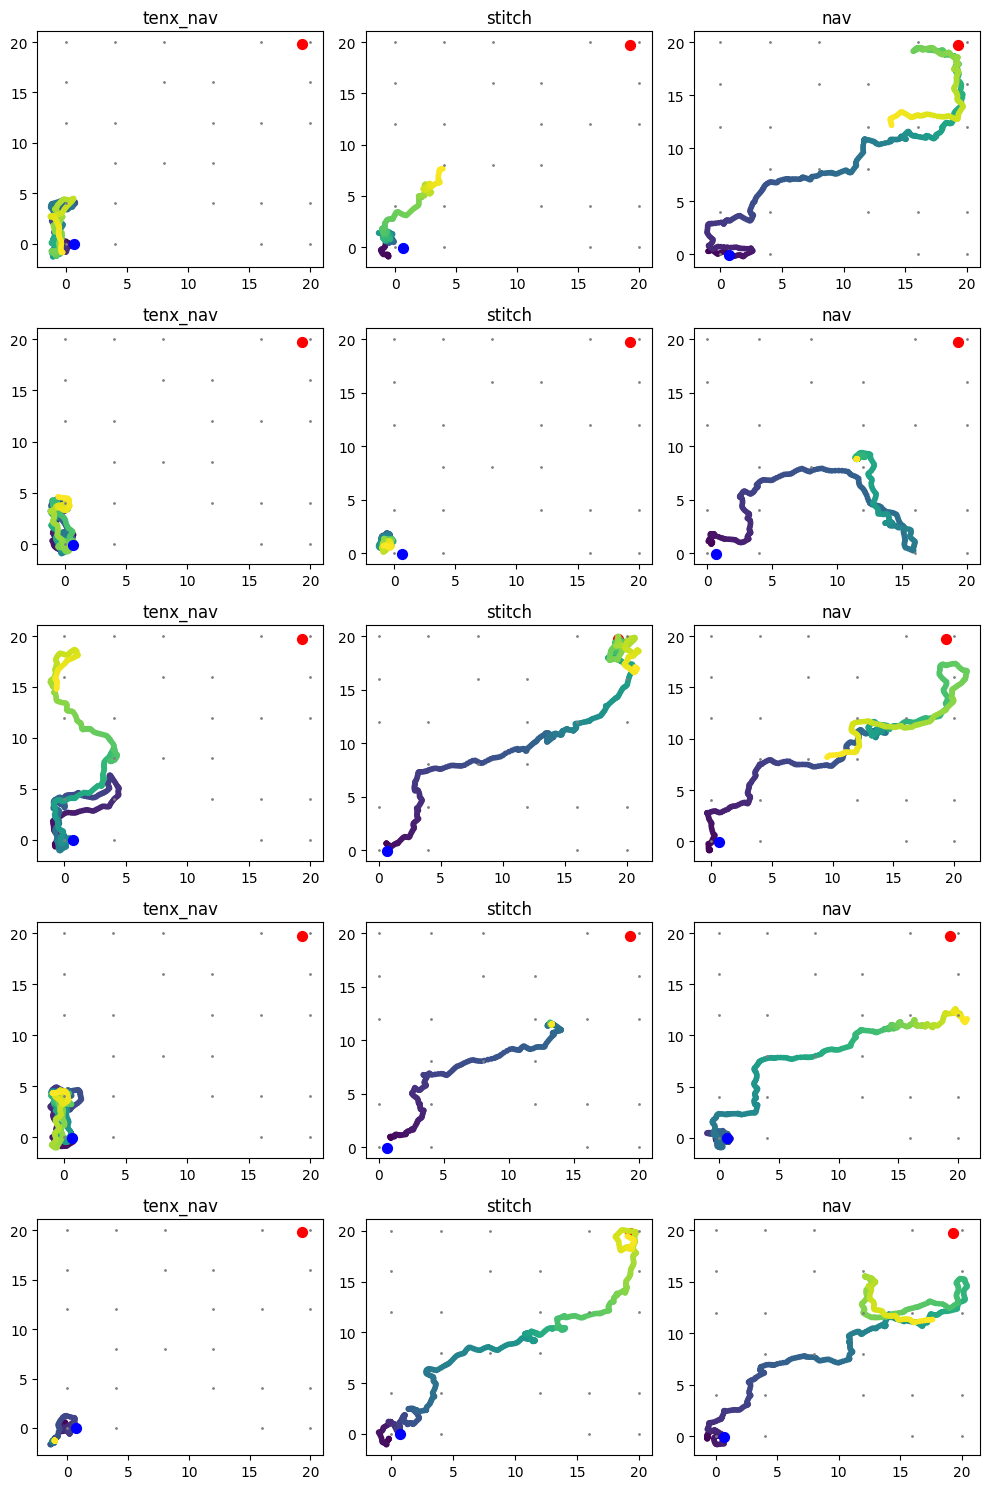

In [31]:
ob, _ = env.reset()
goal_ob = ob.copy()
goal_ob[0] = 20
goal_ob[1] = 20
start = ob.copy()[:2]

noised_goals = []
for _ in range(1):
    goals = goal_ob + 0.5 * np.random.normal(size=goal_ob.shape)
    noised_goals.append(goals)
noised_goals = np.array(noised_goals)

trajs = {'tenx_nav': [], 'stitch': [], 'nav': []}
    # traj = rollout(env, noised_goals, agent, num_steps=500, temperature=0.2)
    # trajs.append(traj)
for curr_agent, name in zip([tenx_nav_agent, stitch_agent, nav_agent], ['tenx_nav', 'stitch', 'nav']):
    for _ in range(5):
        traj = rollout(env, noised_goals, curr_agent, num_steps=500, temperature=0.2)
        trajs[name].append(traj)

fig, ax = plt.subplots(5, 3, figsize=(10, 15))

# for i, traj in enumerate(trajs):
#     plot_axes(ax[i // 3, i % 3], traj, all_cells=all_cells, goals=noised_goals)
for i, (name, traj_list) in enumerate(trajs.items()):
    for j, traj in enumerate(traj_list):
        plot_axes(ax[j, i], traj, all_cells=all_cells, goals=noised_goals, start=start)
        ax[j, i].set_title(name)
plt.tight_layout()
plt.show()

In [12]:
tenx_nav_agent = agent_class.create(
    0,
    example_batch,
    cfgrl_config,
)
tenx_nav_agent = restore_agent(tenx_nav_agent, 'exp/cfgrl/Debug/sd000_20250611_101750', 1000000)

stitch_agent = agent_class.create(
    0,
    example_batch,
    cfgrl_config,
)
stitch_agent = restore_agent(stitch_agent, 'exp/cfgrl/Debug/sd000_20250610_172218', 1000000)

nav_agent = agent_class.create(
    0,
    example_batch,
    cfgrl_config,
)
nav_agent = restore_agent(nav_agent, 'exp/cfgrl/Debug/sd000_20250610_120049', 1000000)

Restored from exp/cfgrl/Debug/sd000_20250611_101750/params_1000000.pkl
Restored from exp/cfgrl/Debug/sd000_20250610_172218/params_1000000.pkl
Restored from exp/cfgrl/Debug/sd000_20250610_120049/params_1000000.pkl


100%|██████████| 500/500 [00:01<00:00, 362.80it/s]


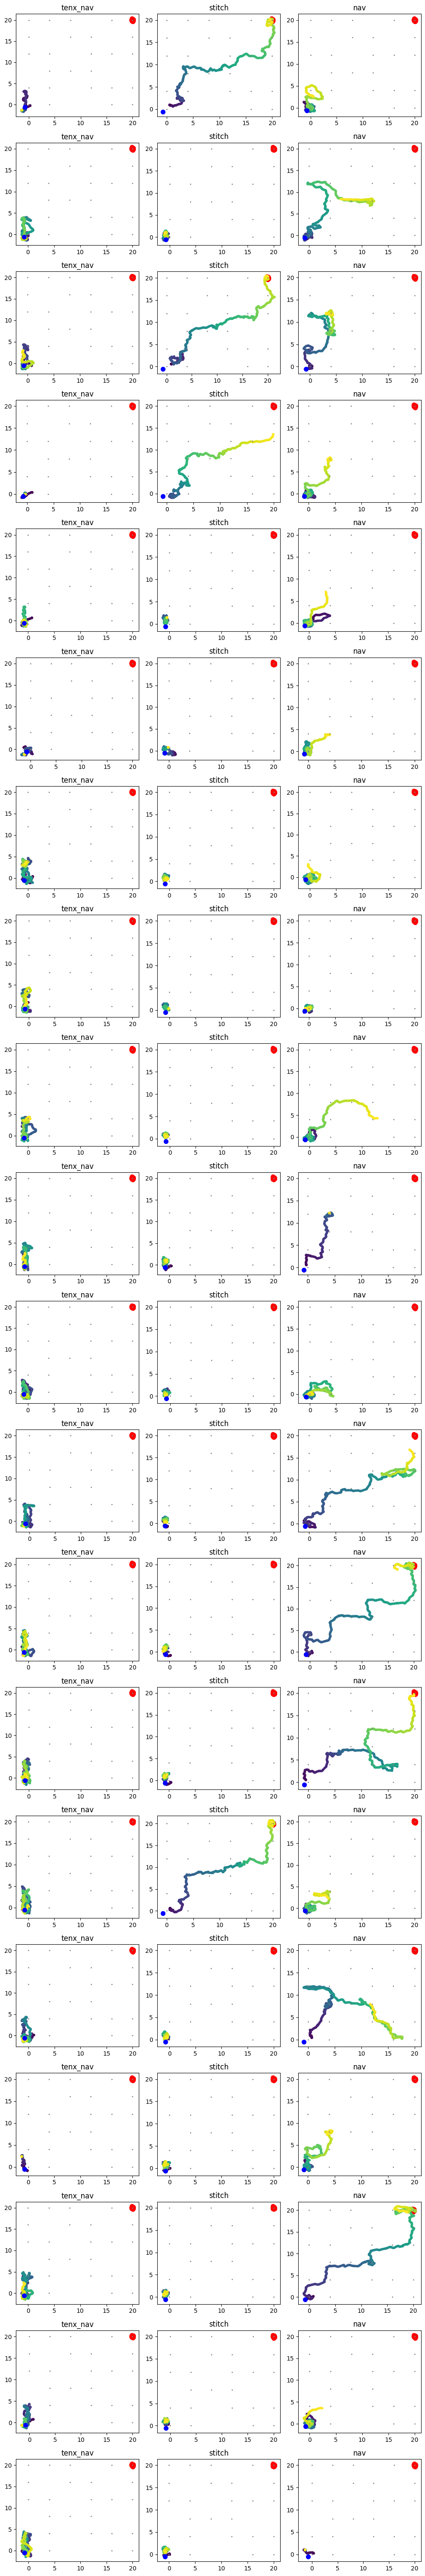

In [36]:
ob, _ = env.reset()
goal_ob = ob.copy()
goal_ob[0] = 20
goal_ob[1] = 20
start = ob.copy()[:2]

noised_goals = []
for _ in range(50):
    goals = goal_ob + 0.1 * np.random.normal(size=goal_ob.shape)
    noised_goals.append(goals)
noised_goals = np.array(noised_goals)

trajs = {'tenx_nav': [], 'stitch': [], 'nav': []}
    # traj = rollout(env, noised_goals, agent, num_steps=500, temperature=0.2)
    # trajs.append(traj)
for curr_agent, name in zip([tenx_nav_agent, stitch_agent, nav_agent], ['tenx_nav', 'stitch', 'nav']):
    for _ in range(20):
        traj = rollout(env, noised_goals, curr_agent, num_steps=500, temperature=0.2)
        trajs[name].append(traj)

fig, ax = plt.subplots(20, 3, figsize=(10, 60))

# for i, traj in enumerate(trajs):
#     plot_axes(ax[i // 3, i % 3], traj, all_cells=all_cells, goals=noised_goals)
for i, (name, traj_list) in enumerate(trajs.items()):
    for j, traj in enumerate(traj_list):
        plot_axes(ax[j, i], traj, all_cells=all_cells, goals=noised_goals, start=start)
        ax[j, i].set_title(name)
plt.tight_layout()
plt.show()

100%|██████████| 500/500 [00:01<00:00, 385.78it/s]


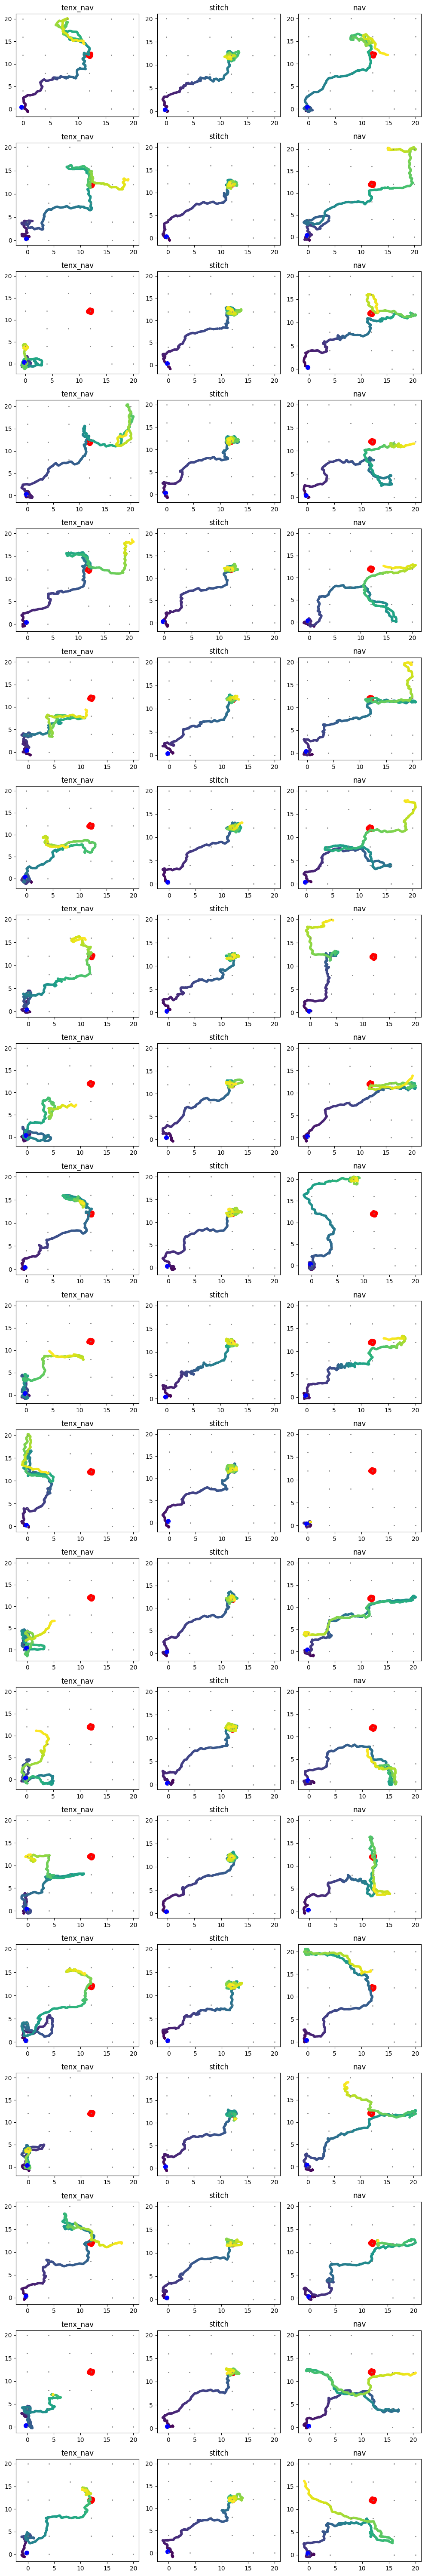

In [37]:
ob, _ = env.reset()
goal_ob = ob.copy()
goal_ob[0] = 12
goal_ob[1] = 12
start = ob.copy()[:2]

noised_goals = []
for _ in range(50):
    goals = goal_ob + 0.1 * np.random.normal(size=goal_ob.shape)
    noised_goals.append(goals)
noised_goals = np.array(noised_goals)

trajs = {'tenx_nav': [], 'stitch': [], 'nav': []}
    # traj = rollout(env, noised_goals, agent, num_steps=500, temperature=0.2)
    # trajs.append(traj)
for curr_agent, name in zip([tenx_nav_agent, stitch_agent, nav_agent], ['tenx_nav', 'stitch', 'nav']):
    for _ in range(20):
        traj = rollout(env, noised_goals, curr_agent, num_steps=500, temperature=0.2)
        trajs[name].append(traj)

fig, ax = plt.subplots(20, 3, figsize=(10, 60))

# for i, traj in enumerate(trajs):
#     plot_axes(ax[i // 3, i % 3], traj, all_cells=all_cells, goals=noised_goals)
for i, (name, traj_list) in enumerate(trajs.items()):
    for j, traj in enumerate(traj_list):
        plot_axes(ax[j, i], traj, all_cells=all_cells, goals=noised_goals, start=start)
        ax[j, i].set_title(name)
plt.tight_layout()
plt.show()

100%|██████████| 500/500 [00:01<00:00, 372.43it/s]


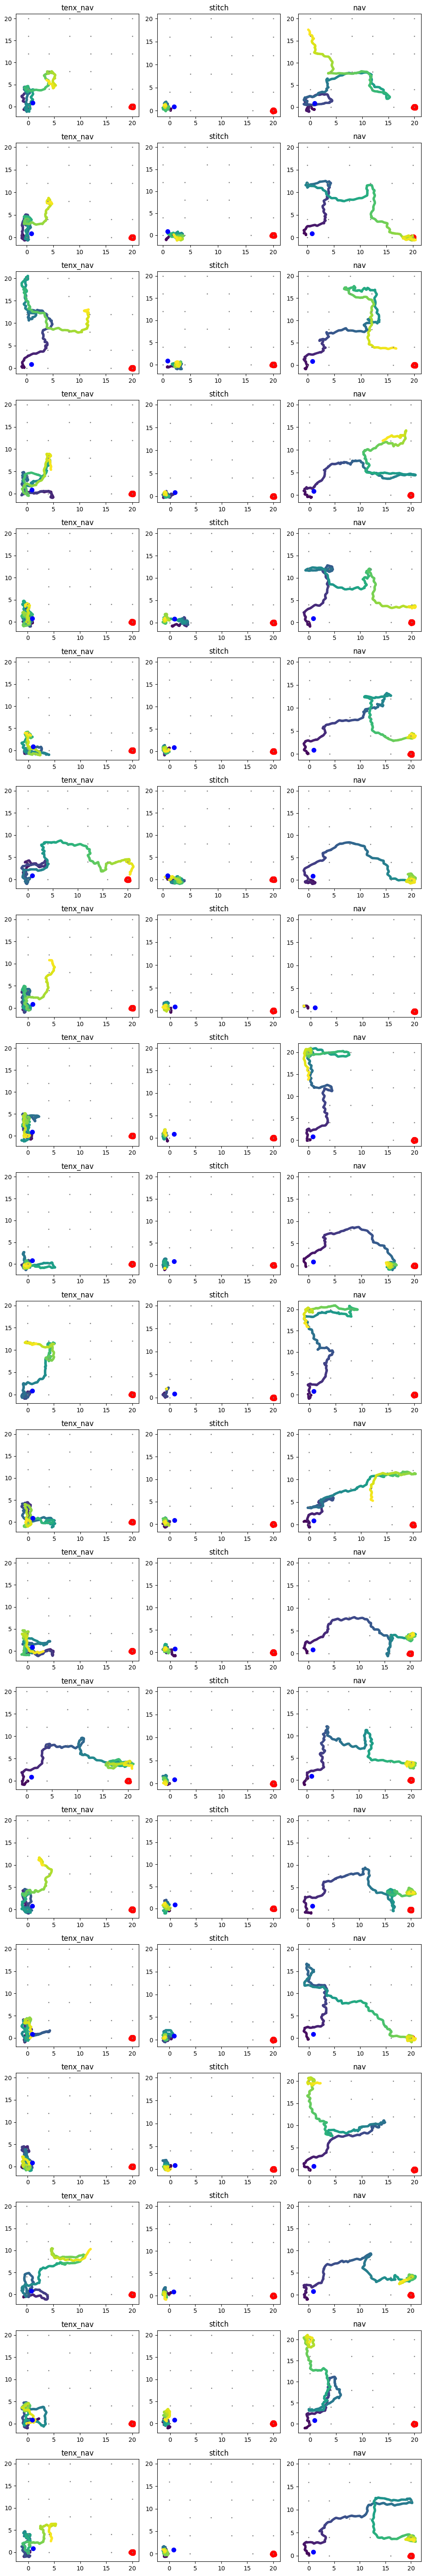

In [38]:
ob, _ = env.reset()
goal_ob = ob.copy()
goal_ob[0] = 20
goal_ob[1] = 0
start = ob.copy()[:2]

noised_goals = []
for _ in range(50):
    goals = goal_ob + 0.1 * np.random.normal(size=goal_ob.shape)
    noised_goals.append(goals)
noised_goals = np.array(noised_goals)

trajs = {'tenx_nav': [], 'stitch': [], 'nav': []}
    # traj = rollout(env, noised_goals, agent, num_steps=500, temperature=0.2)
    # trajs.append(traj)
for curr_agent, name in zip([tenx_nav_agent, stitch_agent, nav_agent], ['tenx_nav', 'stitch', 'nav']):
    for _ in range(20):
        traj = rollout(env, noised_goals, curr_agent, num_steps=500, temperature=0.2)
        trajs[name].append(traj)

fig, ax = plt.subplots(20, 3, figsize=(10, 60))

# for i, traj in enumerate(trajs):
#     plot_axes(ax[i // 3, i % 3], traj, all_cells=all_cells, goals=noised_goals)
for i, (name, traj_list) in enumerate(trajs.items()):
    for j, traj in enumerate(traj_list):
        plot_axes(ax[j, i], traj, all_cells=all_cells, goals=noised_goals, start=start)
        ax[j, i].set_title(name)
plt.tight_layout()
plt.show()

In [39]:
cfgrl_config

action_dim: !!python/object:ml_collections.config_dict.config_dict.FieldReference
  _field_type: &id001 !!python/name:builtins.int ''
  _ops: []
  _required: false
  _value: 8
actor_geom_sample: false
actor_hidden_dims: !!python/tuple
- 512
- 512
- 512
- 512
actor_layer_norm: false
actor_p_curgoal: 0.0
actor_p_randomgoal: 0.0
actor_p_trajgoal: 1.0
agent_name: cfgrl
batch_size: 1024
cfg: 3.0
dataset_class: GCDataset
discount: 0.99
encoder: !!python/object:ml_collections.config_dict.config_dict.FieldReference
  _field_type: !!python/name:builtins.str ''
  _ops: []
  _required: false
  _value: null
flow_steps: 16
frame_stack: !!python/object:ml_collections.config_dict.config_dict.FieldReference
  _field_type: *id001
  _ops: []
  _required: false
  _value: null
gc_negative: true
lr: 0.0003
p_aug: 0.0
value_geom_sample: false
value_p_curgoal: 0.0
value_p_randomgoal: 0.0
value_p_trajgoal: 1.0

In [17]:
from utils.evaluation import supply_rng

In [31]:
env.unwrapped.cur_task_id = 1

100%|██████████| 1000/1000 [00:04<00:00, 230.52it/s]


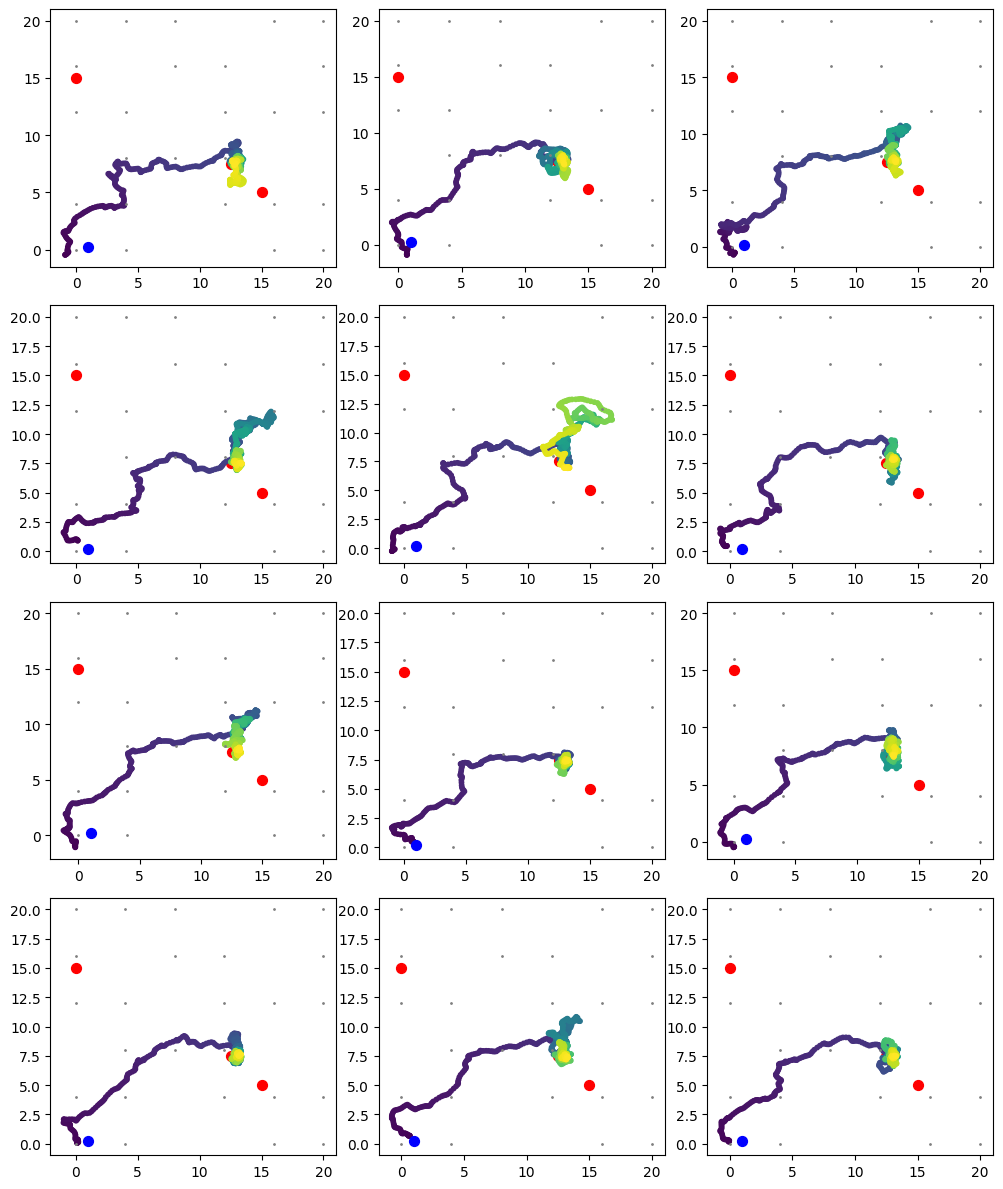

In [37]:
ob, _ = env.reset()
goal_coords = [
    # [8, 8],
    [15, 5],
    [0, 15],
    [12.5, 7.5],
    
]
start = ob.copy()[:2]

goals = []
for goal_coord in goal_coords:
    goal = ob.copy()
    goal[:2] = goal_coord
    goals.append(goal)
goals = np.array(goals)

num_rollouts = 12
num_rows = 4
trajs = []
for _ in range(num_rollouts):
    traj = rollout(env, goals, stitch_agent, num_steps=1000, temperature=0.2)
    trajs.append(traj)

fig, ax = plt.subplots(num_rows, num_rollouts // num_rows, figsize=(10, num_rows * 3))

for i, traj in enumerate(trajs):
    plot_axes(ax[i // 3, i % 3], traj, all_cells=all_cells, goals=goals, start=start)
plt.tight_layout()
plt.show()